<a href="https://colab.research.google.com/github/liballouo/Mahjong/blob/main/Chow_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [2]:
torch.cuda.is_available()

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
class ExampleDataset(Dataset):
    def __init__(self):
        # integer inputs
        # file_name = '/content/drive/MyDrive/專題/Chow_reward_hand_only_0_1.csv'
        # float inputs
        file_name = '/content/drive/MyDrive/專題/Chow_reward_hand_only.csv'
        df = pd.read_csv(file_name)

        xy = df.to_numpy()

        for i in range(len(xy)):
            for j in range(len(xy[i])):
                xy[i][j] = np.array(eval(xy[i][j]))

        x = xy[:, :-1]
        y = xy[:, -1:]

        test_tensor = []
        test_tensor.append(torch.tensor([list(arr) for arr in x]))

        flatten_tensor = torch.tensor([list(arr) for arr in x])

        # for i in range(len(test_tensor)):
        #     torch.flatten(flatten_tensor[i])

        tensor_y = torch.tensor([list(arr) for arr in y])

        x = flatten_tensor

        # Reshape input x to have dimensions (batch_size, 2, 34)
        # print(x.shape)
        x = x.reshape(-1, 2, 34)
        # print(x.shape)

        # float inputs
        self.x = torch.tensor(x, dtype=torch.float32)
        # integer inputs
        # self.x = torch.tensor(x, dtype=torch.int32)

        self.y = tensor_y
        self.y = tensor_y.squeeze(1)  # Reshape label tensor to remove the extra dimension

        self.n_samples = xy.shape[0]

    def __getitem__(self, index):
        return self.x[index], self.y[index]

    def __len__(self):
        return self.n_samples


In [5]:
dataset = ExampleDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# print(len(dataset))

<ipython-input-4-a4a961ffc67e>:19: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  test_tensor.append(torch.tensor([list(arr) for arr in x]))
<ipython-input-4-a4a961ffc67e>:36: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.x = torch.tensor(x, dtype=torch.float32)


In [6]:
print(len(dataset.x))

56143


In [7]:
# Random split
# length of training set
training_set_size = int(len(dataset) * 0.8)
# length of test set
test_set_size = len(dataset) - training_set_size
training_set, test_set = random_split(dataset, [training_set_size, test_set_size])

training_dataloader = DataLoader(training_set, batch_size=batch_size, shuffle=True, pin_memory=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True, pin_memory=True)

print(len(training_dataloader))
print(len(test_dataloader))

1404
351


In [8]:
class Majhong_Model(nn.Module):
    def __init__(self):
        super(Majhong_Model, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv_last = nn.Conv1d(in_channels=256, out_channels=32, kernel_size=3, stride=1)
        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.conv1(x)
        out = self.relu(out)
        for i in range(2):
          out = self.conv2(out)
          out = self.relu(out)

        out = self.conv_last(out)
        out = self.relu(out)
        out = out.view(batch_size, -1)  # Flatten the output of convolutional layer
        # out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


# Model initiation

In [9]:
model = Majhong_Model()
criterion = nn.CrossEntropyLoss()

model = model.to(device)
criterion = criterion.to(device)

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Test

In [ ]:
def test(net, dataLoader, criterion, show=False):
  net.eval()
  totalLoss = 0.0
  accuracy = 0.0
  count = 0
  for x, label in dataLoader:
    x = x.to(device, dtype=torch.float32)
    label = label.to(device, dtype=torch.float32)
    output = net(x)
    loss = criterion(output, label)
    _, predicted = torch.max(output.data, dim=1)
    check_label = torch.Tensor()
    check_label = torch.argmax(label, dim=1)
    count += len(x)
    accuracy += (predicted == check_label).sum().item()
    totalLoss += loss.item()*len(label)
  if show == True:
    print("Test Loss: {}".format(totalLoss / count))
    print("Test Accuracy: {}".format(accuracy / count))
  return (totalLoss / count, accuracy / count)


# Test (confusion matrix)

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def test(net, testLoader, criterion, show=False):
    net.eval()
    totalLoss = 0
    correct = 0
    count = 0
    all_predicted = []
    all_true = []

    for x, label in testLoader:
        x = x.to(device, dtype=torch.float32)
        label = label.to(device, dtype=torch.float32)
        output = net(x)
        print(output)
        loss = criterion(output, label)
        _, predicted = torch.max(output.data, 1)
        check_label = torch.Tensor()
        check_label = torch.argmax(label, dim=1)

        count += len(x)
        correct += (predicted == check_label).sum().item()
        totalLoss += loss.item() * len(label)

        all_predicted.extend(predicted.tolist())
        all_true.extend(check_label.tolist())

    # Compute the confusion matrix
    cm = confusion_matrix(all_true, all_predicted)

    # Calculate accuracy
    accuracy = correct / count

    if show == True:
      print("Test Loss: {:.4f}".format(totalLoss / count))
      print("Test Accuracy: {:.2f}%".format(accuracy * 100))

    # Create a heatmap using seaborn
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')

    # Add labels and title
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')

    # Display the chart
    plt.show()
    print('Accuracy :' + str(accuracy * 100) +'%')
    return (totalLoss / count, accuracy)



# Check best model

串流輸出內容已截斷至最後 5000 行。
        [1.9319e-04, 7.9716e-06, 9.9980e-01, 1.9726e-06],
        [1.3183e-04, 9.9986e-01, 5.3461e-06, 4.0206e-12],
        [5.7867e-04, 8.8960e-08, 4.9998e-05, 9.9937e-01],
        [6.5050e-05, 2.3891e-08, 8.7828e-06, 9.9993e-01],
        [5.1055e-01, 1.6653e-04, 4.8924e-01, 3.9055e-05],
        [2.0286e-04, 2.9370e-06, 9.9979e-01, 7.7224e-07],
        [3.5391e-04, 9.9964e-01, 9.7776e-07, 1.8002e-07],
        [5.0006e-01, 4.9991e-01, 4.0185e-06, 2.9945e-05],
        [4.3367e-05, 2.8765e-06, 9.9995e-01, 7.7867e-07],
        [2.3753e-01, 5.1206e-04, 2.3890e-01, 5.2306e-01],
        [6.4139e-03, 5.3703e-07, 6.6045e-06, 9.9358e-01],
        [3.5648e-04, 9.9964e-01, 5.4039e-06, 1.4582e-07],
        [2.0657e-04, 9.9979e-01, 2.5221e-06, 5.7113e-10],
        [2.2570e-04, 9.9977e-01, 5.2655e-07, 3.5013e-08],
        [6.1435e-01, 1.2728e-07, 7.7367e-05, 3.8557e-01],
        [2.1484e-01, 2.3868e-05, 4.9932e-01, 2.8582e-01],
        [3.5200e-04, 1.0277e-05, 9.9964e-01, 8.9275

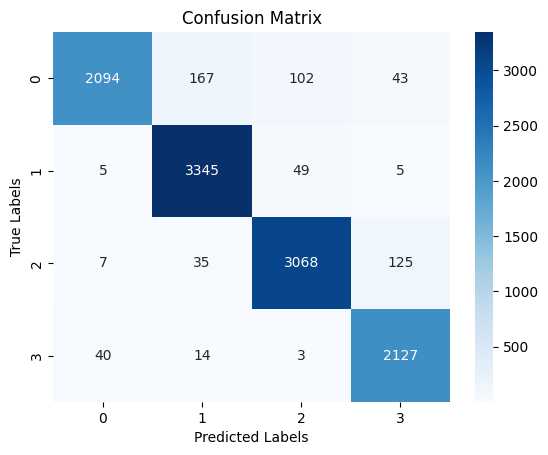

Accuracy :94.70122005521418%


In [11]:
best_model = torch.load('/content/drive/MyDrive/專題/Chow model/best_model.pth')

model = Majhong_Model()
model.load_state_dict(best_model['model_state_dict'])

model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(best_model['optimizer_state_dict'])

model.eval()

_, best_accuracy = test(model, test_dataloader, criterion)

In [ ]:
print(best_accuracy)


0.9428266096713865


# Training model (save model)

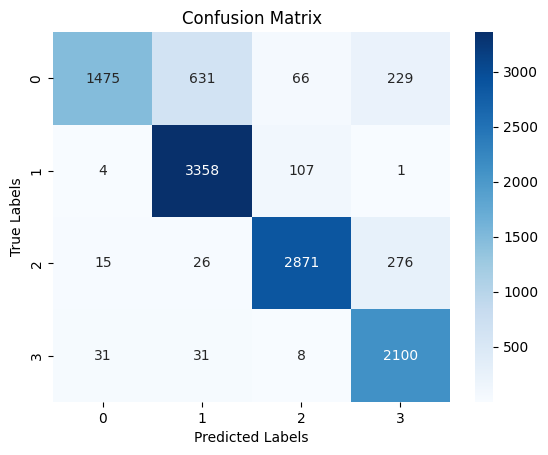

Accuracy :87.30964467005076%
Epoch 1/150, Loss: 1.0691514015197754


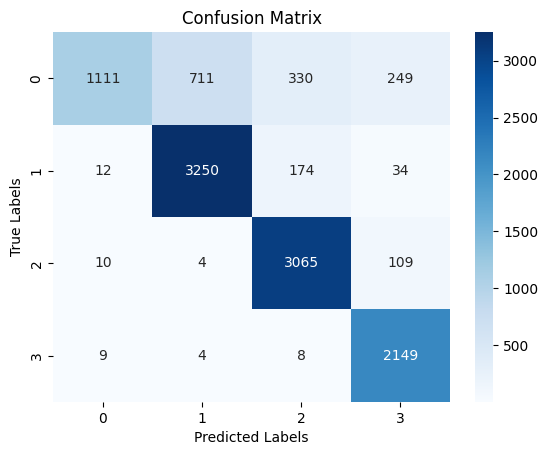

Accuracy :85.27028230474663%
Epoch 2/150, Loss: 1.1214057207107544


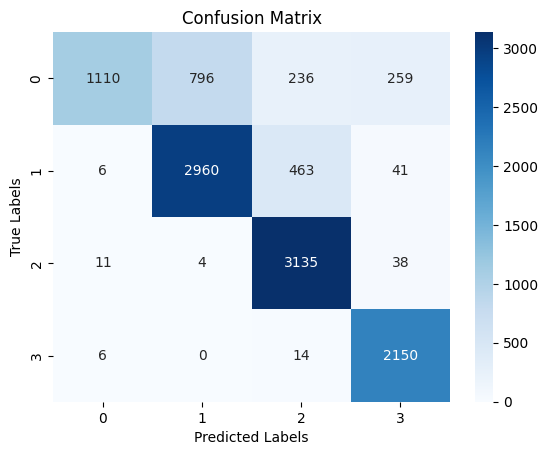

Accuracy :83.31106955205271%
Epoch 3/150, Loss: 1.120017409324646


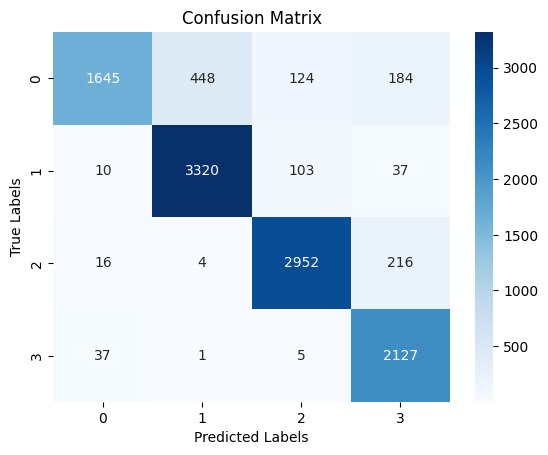

Accuracy :89.44696767298959%
Epoch 4/150, Loss: 1.122582197189331


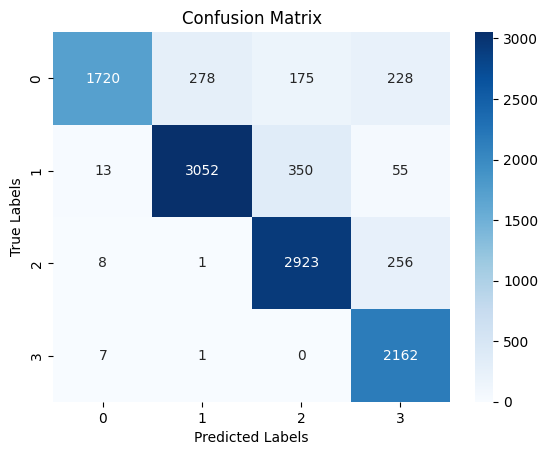

Accuracy :87.78163683319976%
Epoch 5/150, Loss: 1.11240553855896


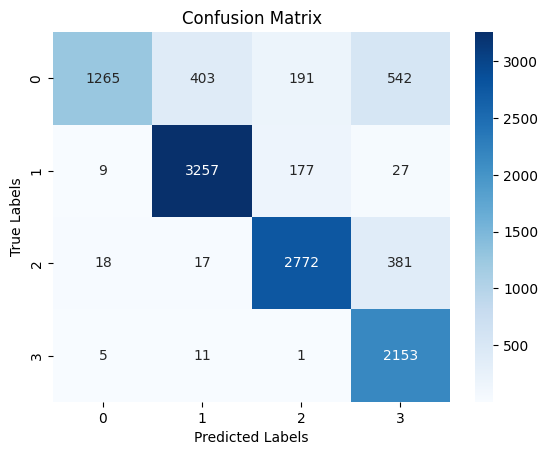

Accuracy :84.13037670317927%
Epoch 6/150, Loss: 1.1371102333068848


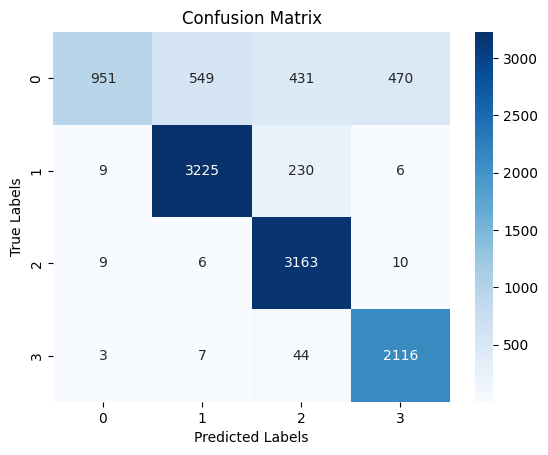

Accuracy :84.20162080327724%
Epoch 7/150, Loss: 1.0996509790420532


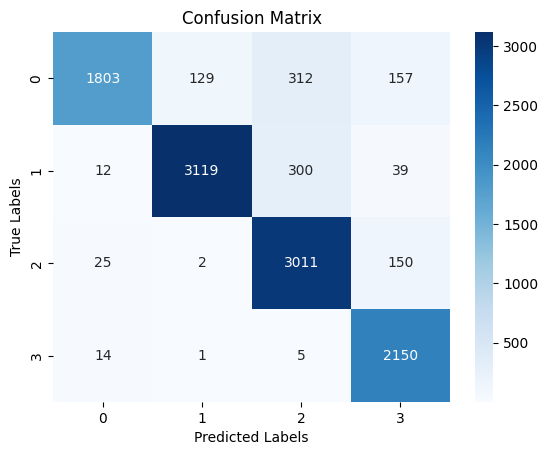

Accuracy :89.79428266096714%
Epoch 8/150, Loss: 1.0932326316833496


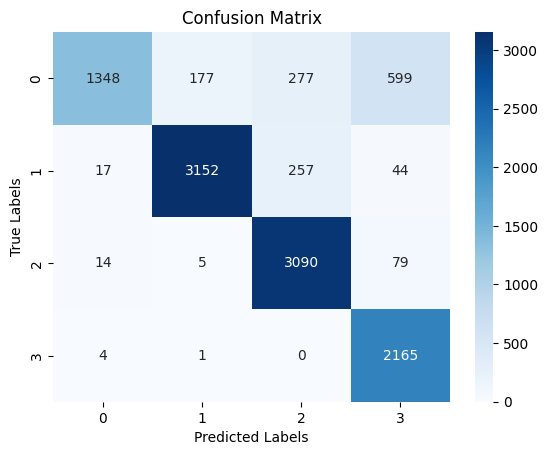

Accuracy :86.87327455695075%
Epoch 9/150, Loss: 1.0958447456359863


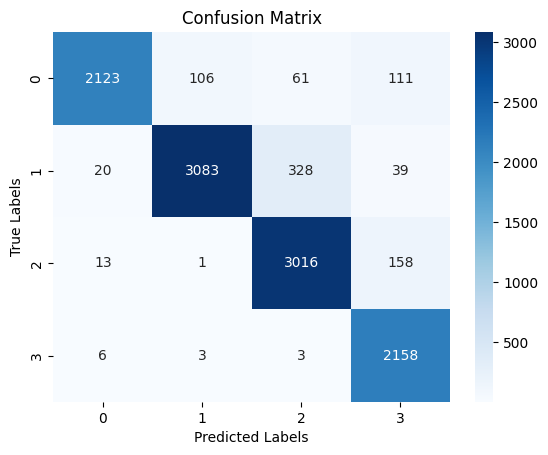

Accuracy :92.43921987710392%
Epoch 10/150, Loss: 1.1455979347229004


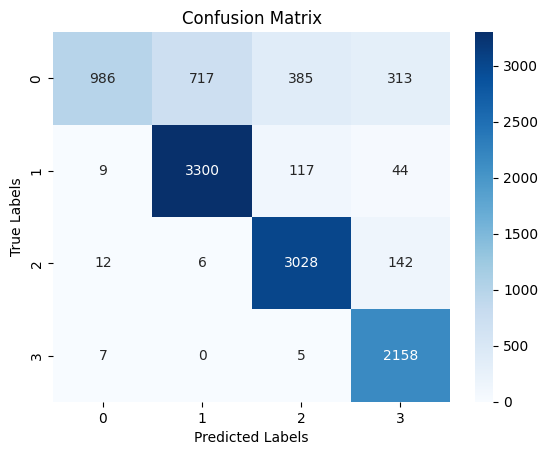

Accuracy :84.3530145159854%
Epoch 11/150, Loss: 1.1022396087646484


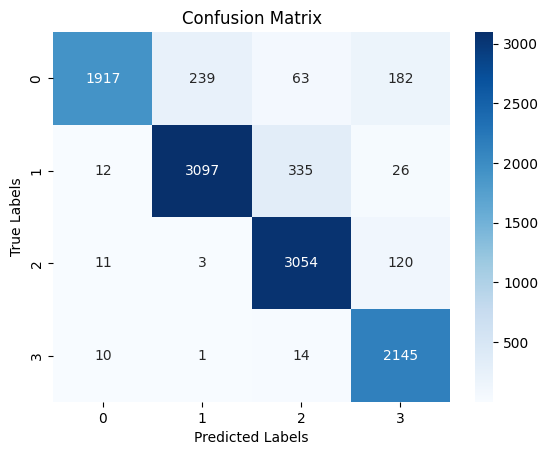

Accuracy :90.951999287559%
Epoch 12/150, Loss: 1.132710576057434


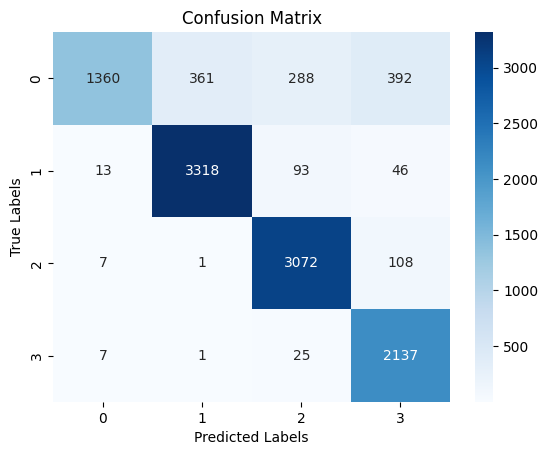

Accuracy :88.0488022085671%
Epoch 13/150, Loss: 1.1390366554260254


Accuracy :92.15424347671208%
Epoch 14/150, Loss: 1.1297022104263306


Accuracy :87.9864636209814%
Epoch 15/150, Loss: 1.1374762058258057


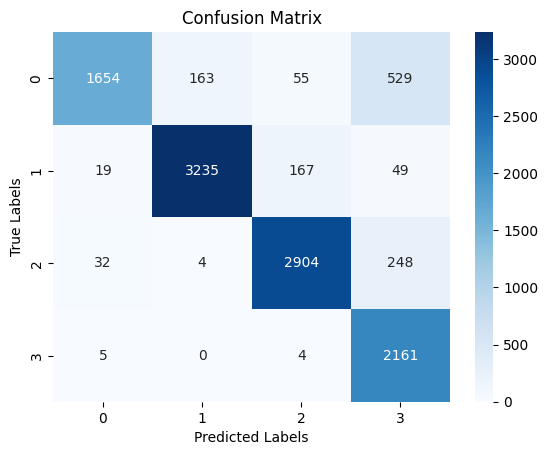

Accuracy :88.64547154688752%
Epoch 16/150, Loss: 1.1123206615447998


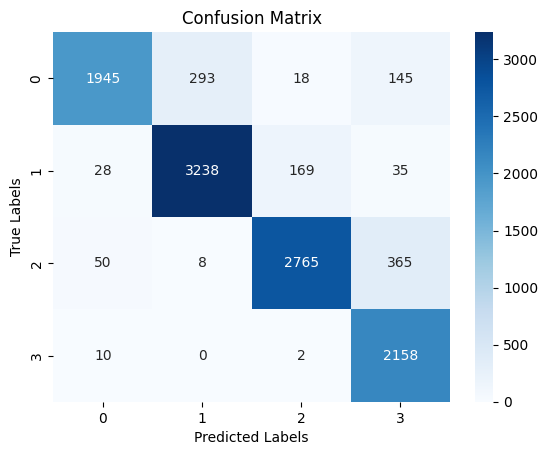

Accuracy :89.99910944874877%
Epoch 17/150, Loss: 1.0959234237670898


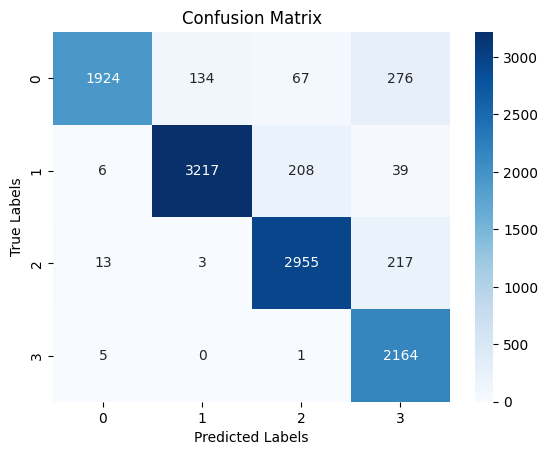

Accuracy :91.37055837563452%
Epoch 18/150, Loss: 1.1420996189117432


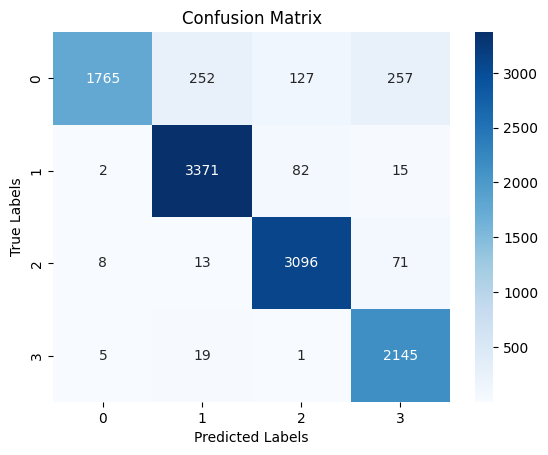

Accuracy :92.41250333956718%
Epoch 19/150, Loss: 1.1320544481277466


Accuracy :81.12921898655267%
Epoch 20/150, Loss: 1.1019177436828613


Accuracy :86.00943984326298%
Epoch 21/150, Loss: 1.096843957901001


Accuracy :87.75492029566301%
Epoch 22/150, Loss: 1.1054280996322632


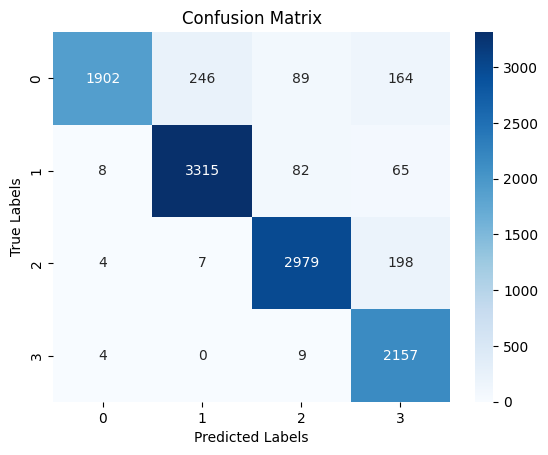

Accuracy :92.19877103927331%
Epoch 23/150, Loss: 1.1135869026184082


Accuracy :89.45587318550182%
Epoch 24/150, Loss: 1.1158852577209473


Accuracy :87.54118799536913%
Epoch 25/150, Loss: 1.1387497186660767


Accuracy :85.43058152996706%
Epoch 26/150, Loss: 1.1257975101470947


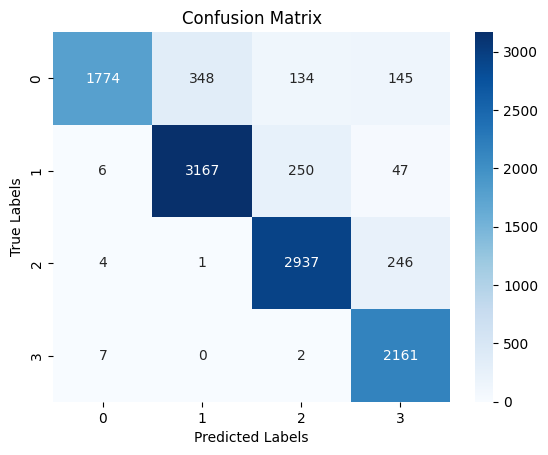

Accuracy :89.40244011042836%
Epoch 27/150, Loss: 1.1199817657470703


Accuracy :86.40128239380176%
Epoch 28/150, Loss: 1.1128073930740356


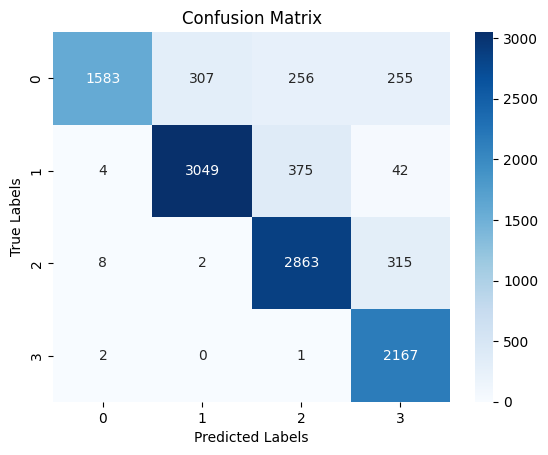

Accuracy :86.04506189331195%
Epoch 29/150, Loss: 1.0559353828430176


Accuracy :90.77388903731409%
Epoch 30/150, Loss: 1.1108458042144775


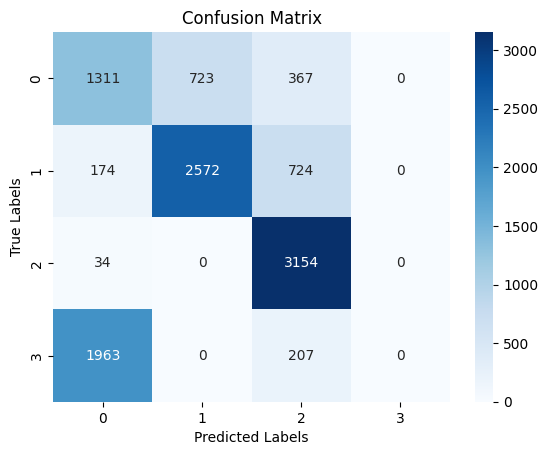

Accuracy :62.66809154866863%
Epoch 31/150, Loss: 1.206379771232605


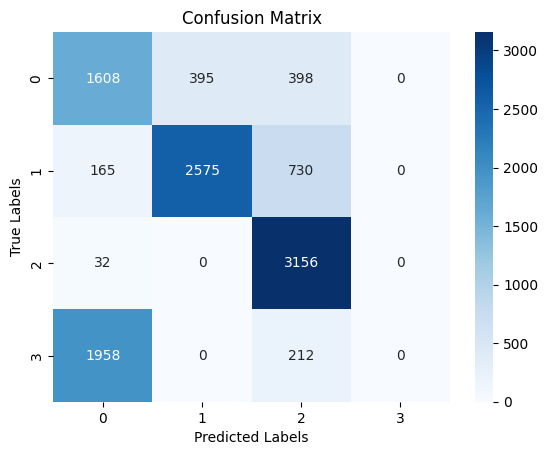

Accuracy :65.35755632736664%
Epoch 32/150, Loss: 1.157461166381836


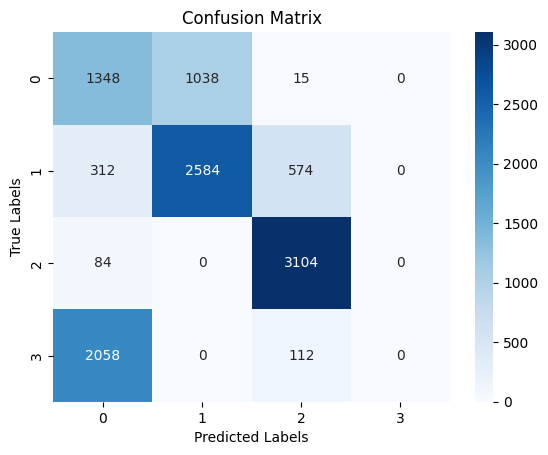

Accuracy :62.65918603615638%
Epoch 33/150, Loss: 1.2128524780273438


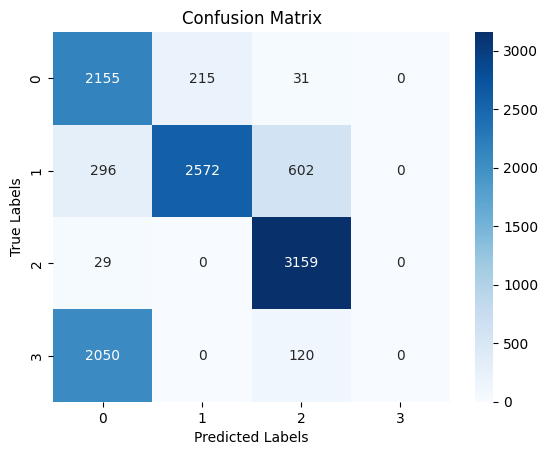

Accuracy :70.22887167156469%
Epoch 34/150, Loss: 1.171123743057251


Accuracy :62.06251669783596%
Epoch 35/150, Loss: 1.204884648323059


Accuracy :61.857689910054326%
Epoch 36/150, Loss: 1.21134352684021


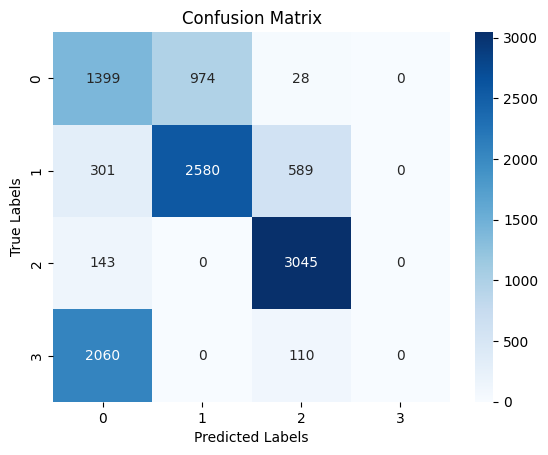

Accuracy :62.55231988600944%
Epoch 37/150, Loss: 1.2155643701553345


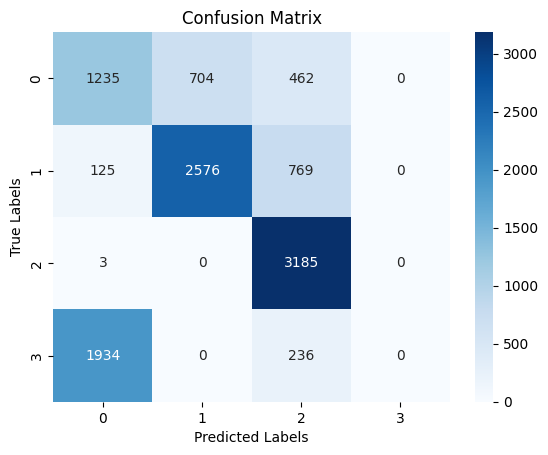

Accuracy :62.30296553566658%
Epoch 38/150, Loss: 1.1993967294692993


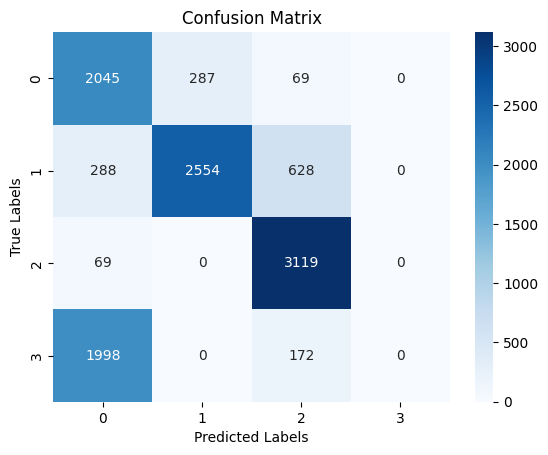

Accuracy :68.73274556950753%
Epoch 39/150, Loss: 1.2702391147613525


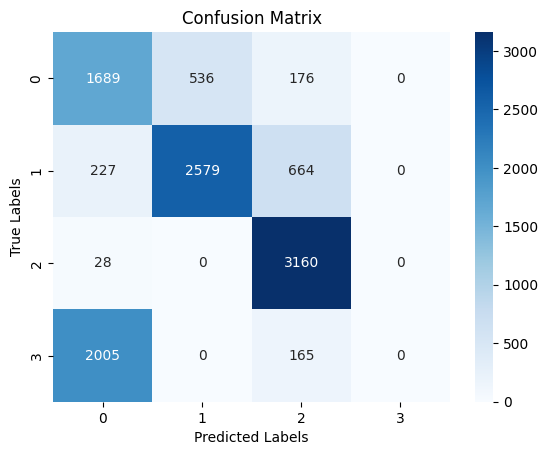

Accuracy :66.15014694095646%
Epoch 40/150, Loss: 1.1534204483032227


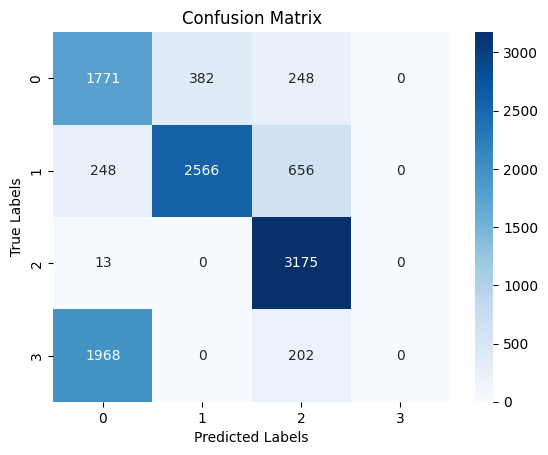

Accuracy :66.89820999198504%
Epoch 41/150, Loss: 1.2122913599014282


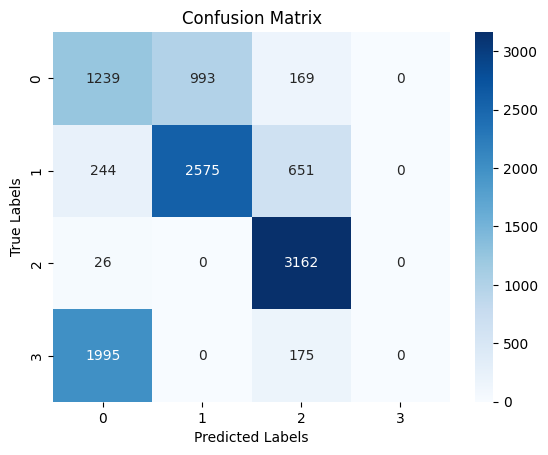

Accuracy :62.124855285421674%
Epoch 42/150, Loss: 1.126775860786438


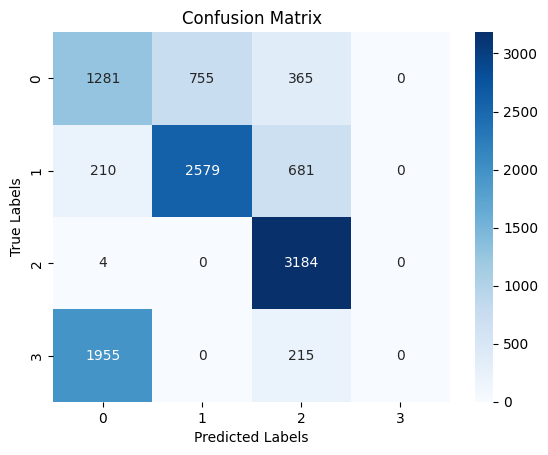

Accuracy :62.73043013625434%
Epoch 43/150, Loss: 1.2855859994888306


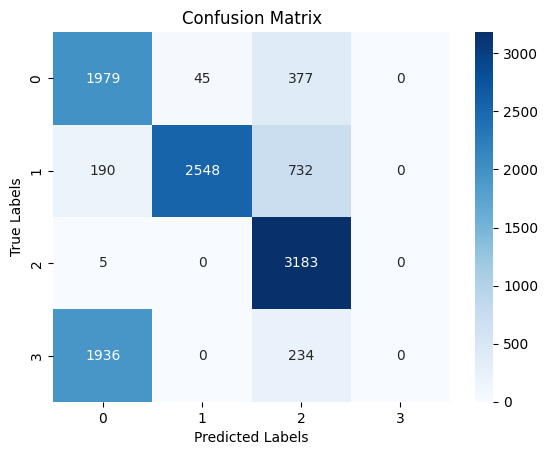

Accuracy :68.66150146940957%
Epoch 44/150, Loss: 1.2665172815322876


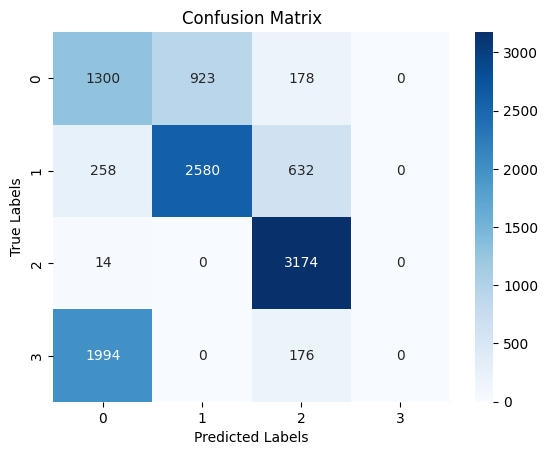

Accuracy :62.8194852613768%
Epoch 45/150, Loss: 1.2441670894622803


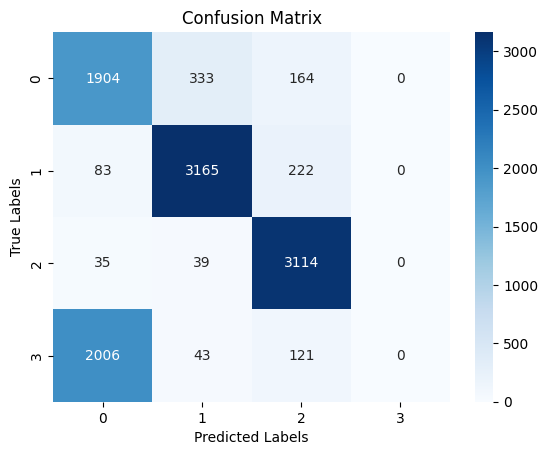

Accuracy :72.87380888770149%
Epoch 46/150, Loss: 1.171430230140686


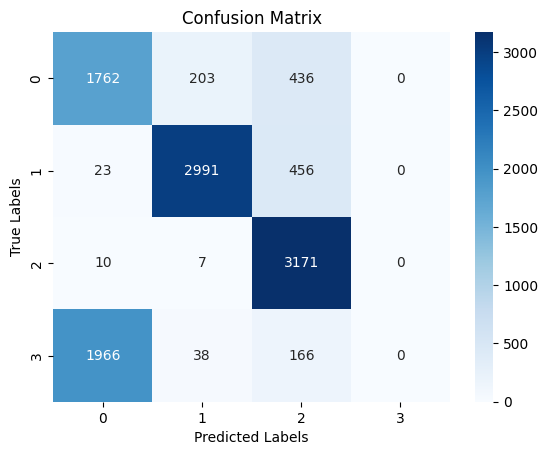

Accuracy :70.56728114703002%
Epoch 47/150, Loss: 1.155180811882019


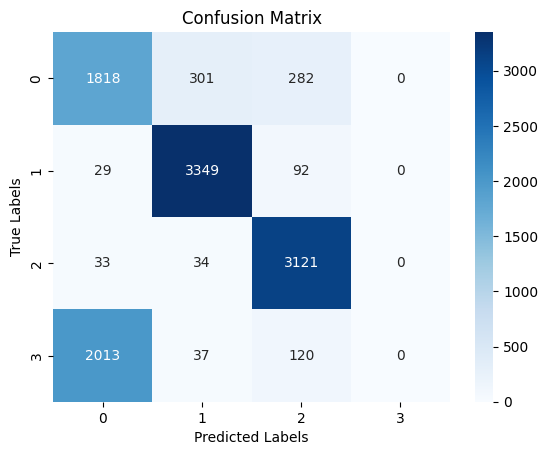

Accuracy :73.80888770148722%
Epoch 48/150, Loss: 1.1327229738235474


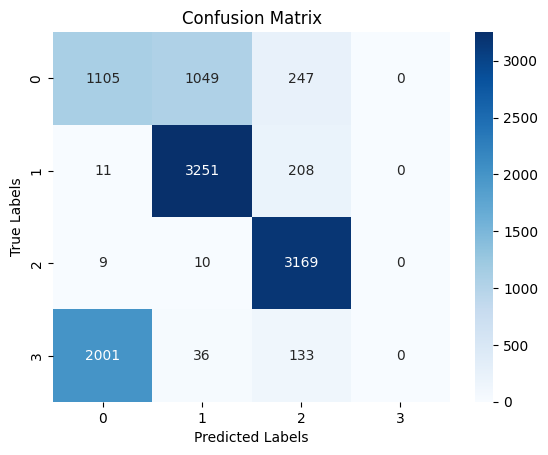

Accuracy :67.01398165464423%
Epoch 49/150, Loss: 1.2198586463928223


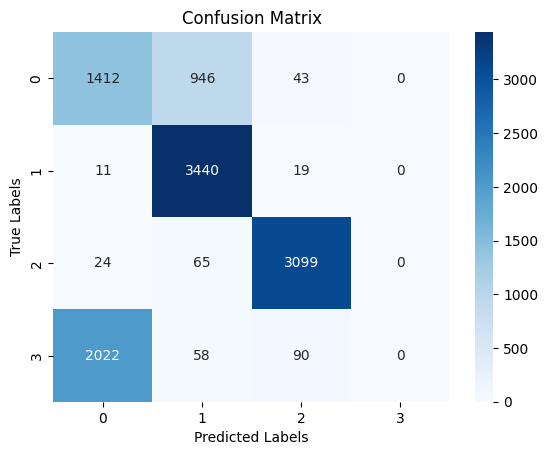

Accuracy :70.80772998486063%
Epoch 50/150, Loss: 1.233404278755188


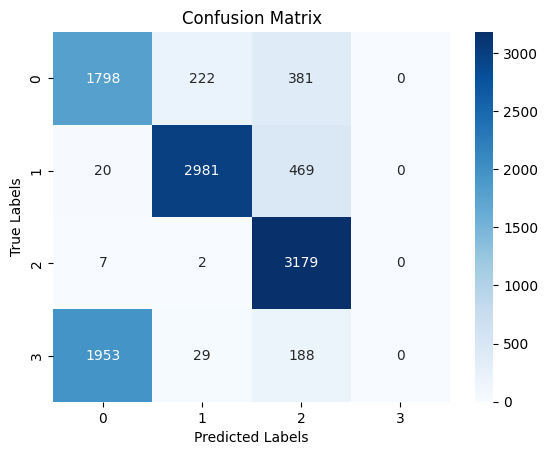

Accuracy :70.87006857244634%
Epoch 51/150, Loss: 1.2078328132629395


Accuracy :75.65232879152195%
Epoch 52/150, Loss: 1.1840671300888062


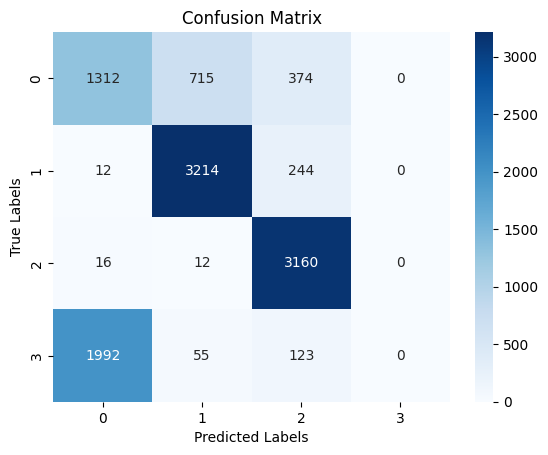

Accuracy :68.44776916911567%
Epoch 53/150, Loss: 1.2159148454666138


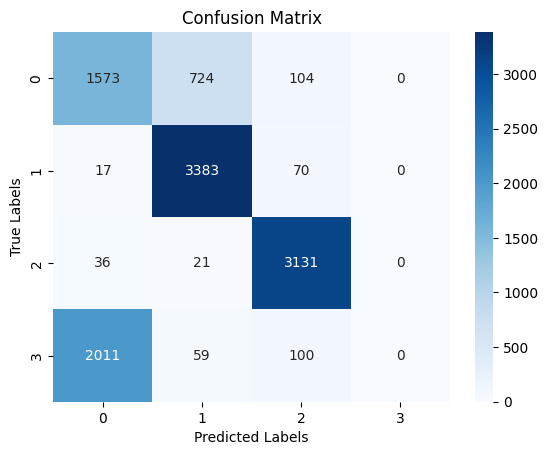

Accuracy :72.01887968652596%
Epoch 54/150, Loss: 1.1643580198287964


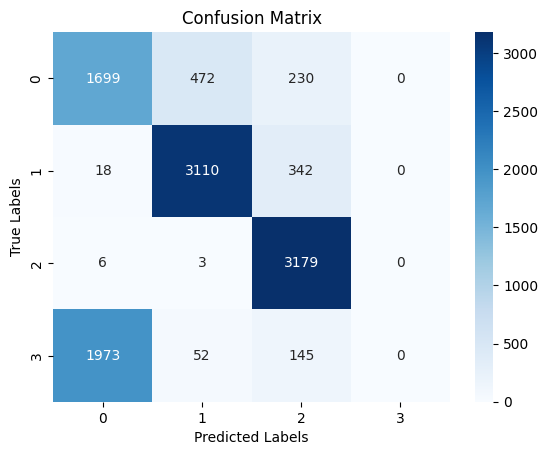

Accuracy :71.1372339478137%
Epoch 55/150, Loss: 1.160261869430542


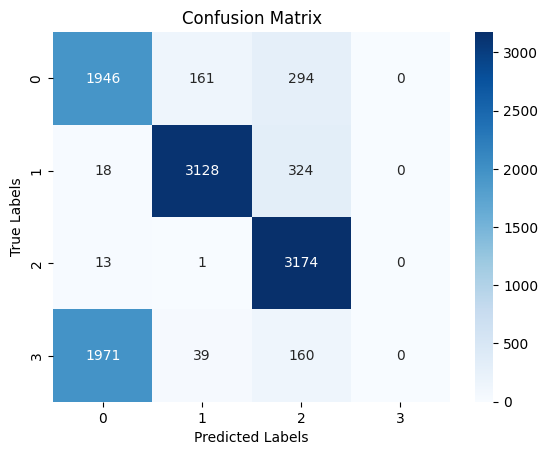

Accuracy :73.45266720099741%
Epoch 56/150, Loss: 1.1765773296356201


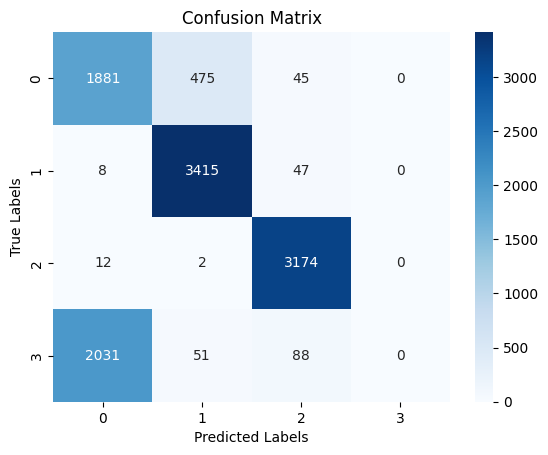

Accuracy :75.42969097871583%
Epoch 57/150, Loss: 1.263288140296936


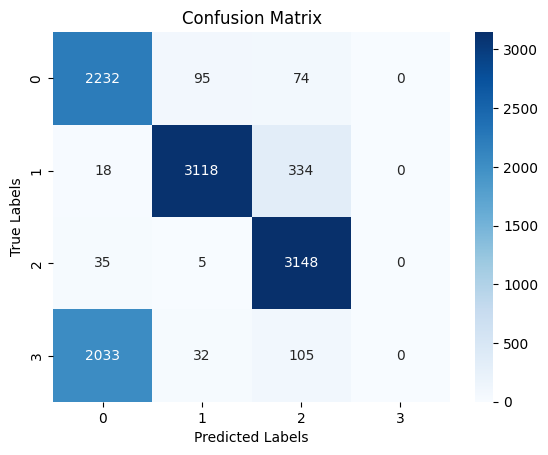

Accuracy :75.6790453290587%
Epoch 58/150, Loss: 1.1673343181610107


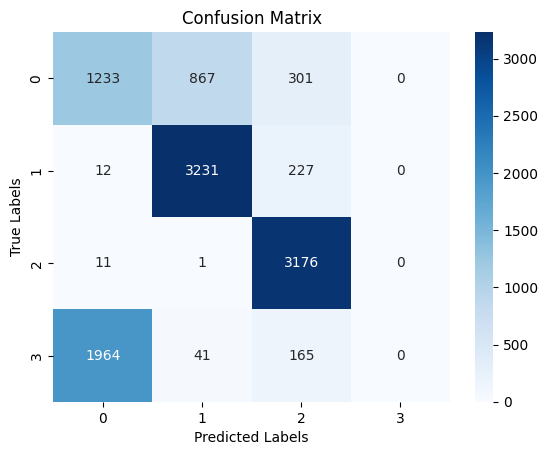

Accuracy :68.0381155935524%
Epoch 59/150, Loss: 1.1528466939926147


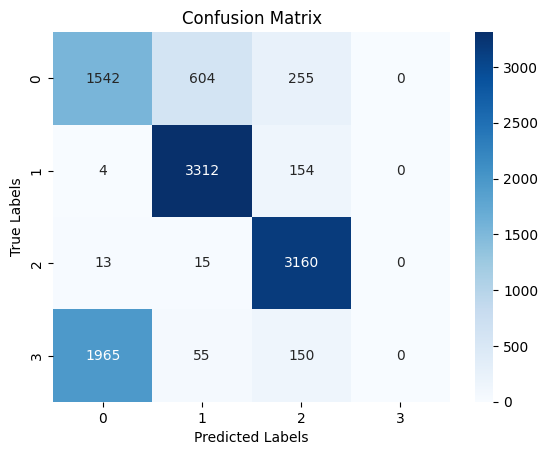

Accuracy :71.36877727313207%
Epoch 60/150, Loss: 1.2175400257110596


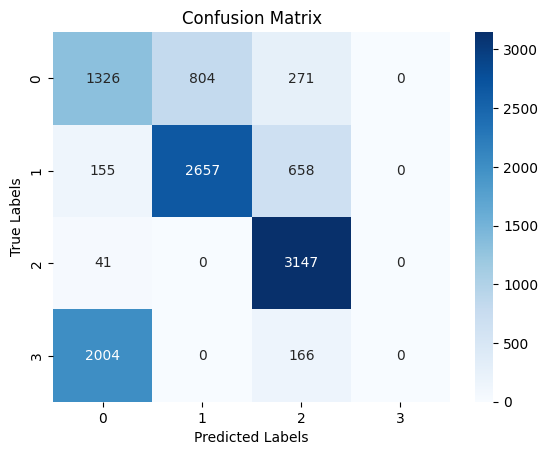

Accuracy :63.49630421230742%
Epoch 61/150, Loss: 1.1771842241287231


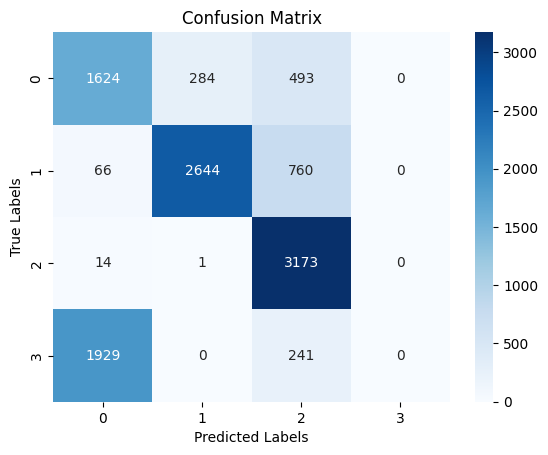

Accuracy :66.26591860361563%
Epoch 62/150, Loss: 1.1837185621261597


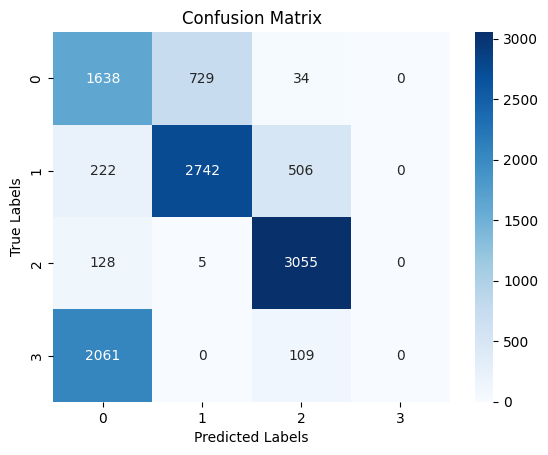

Accuracy :66.21248552854216%
Epoch 63/150, Loss: 1.1726088523864746


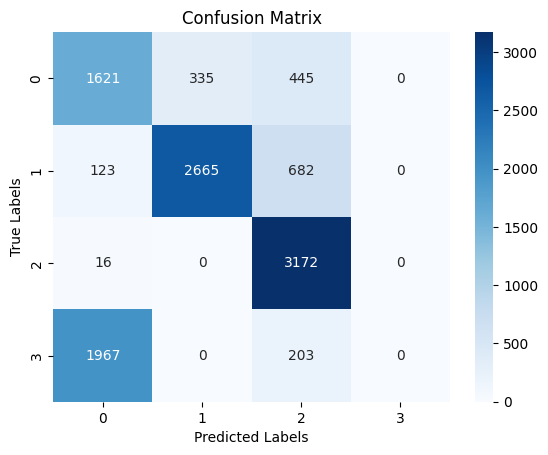

Accuracy :66.4173123163238%
Epoch 64/150, Loss: 1.2138046026229858


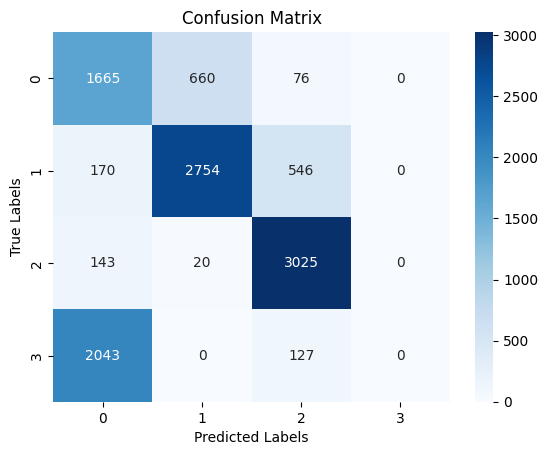

Accuracy :66.29263514115237%
Epoch 65/150, Loss: 1.1856894493103027


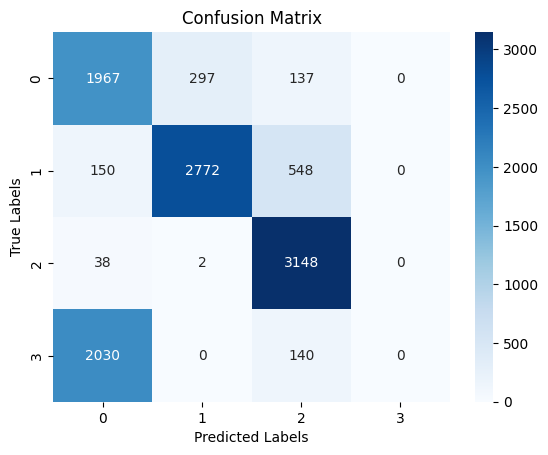

Accuracy :70.23777718407695%
Epoch 66/150, Loss: 1.1973416805267334


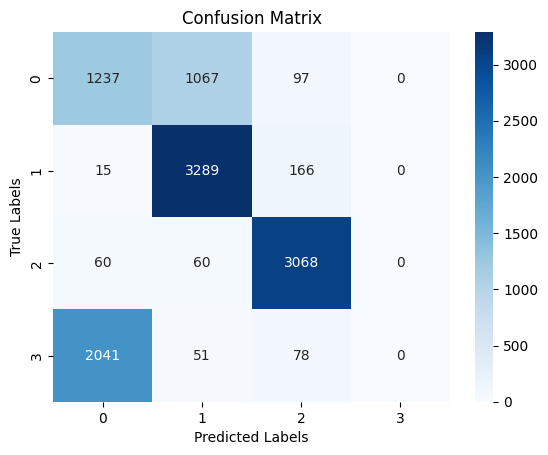

Accuracy :67.62846201798914%
Epoch 67/150, Loss: 1.2028343677520752


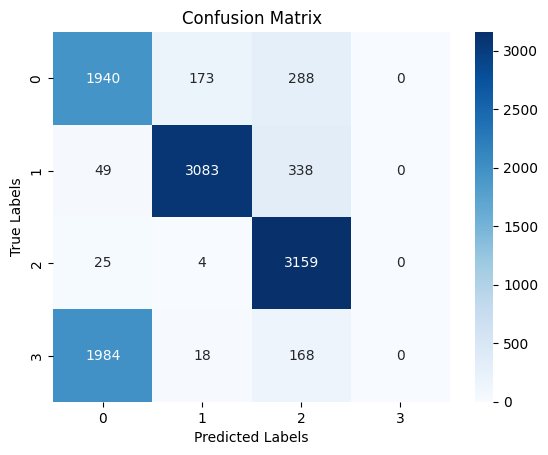

Accuracy :72.86490337518924%
Epoch 68/150, Loss: 1.1956990957260132


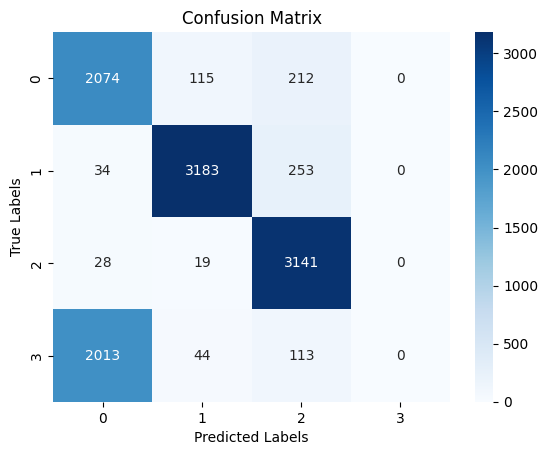

Accuracy :74.78849407783417%
Epoch 69/150, Loss: 1.136859655380249


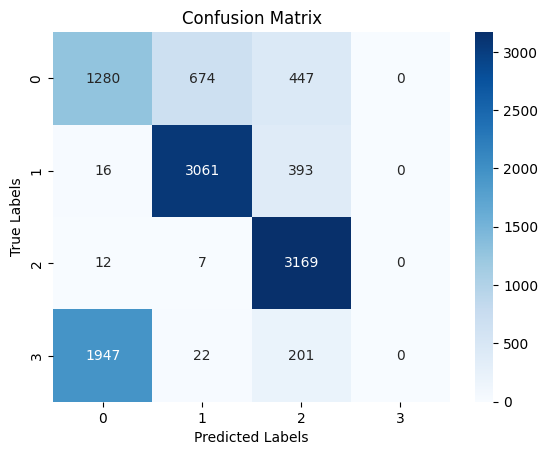

Accuracy :66.88039896696056%
Epoch 70/150, Loss: 1.1664267778396606


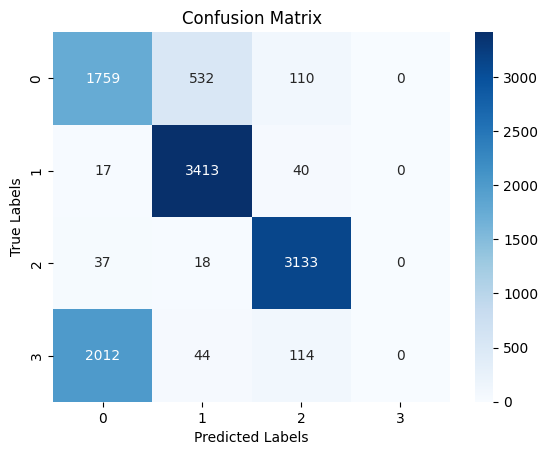

Accuracy :73.96028141419538%
Epoch 71/150, Loss: 1.259378433227539


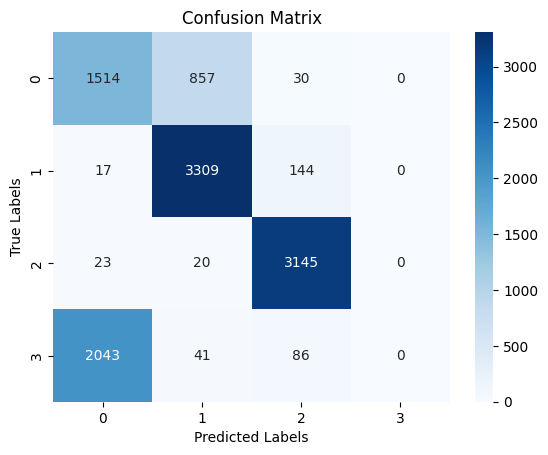

Accuracy :70.9591236975688%
Epoch 72/150, Loss: 1.178174376487732


Accuracy :68.4922967316769%
Epoch 73/150, Loss: 1.2244279384613037


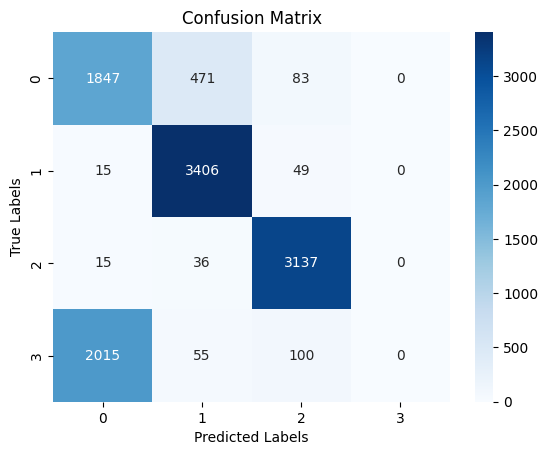

Accuracy :74.71724997773622%
Epoch 74/150, Loss: 1.1986173391342163


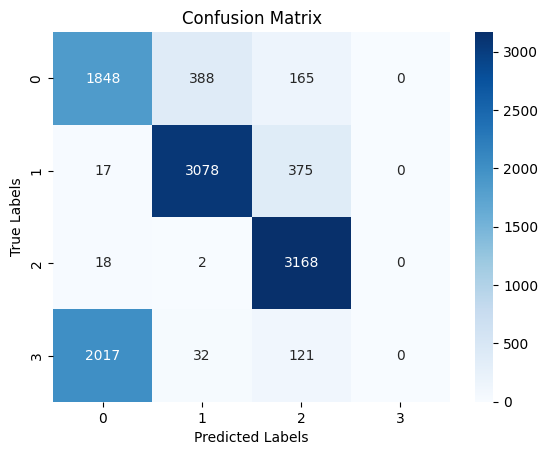

Accuracy :72.08121827411168%
Epoch 75/150, Loss: 1.2507448196411133


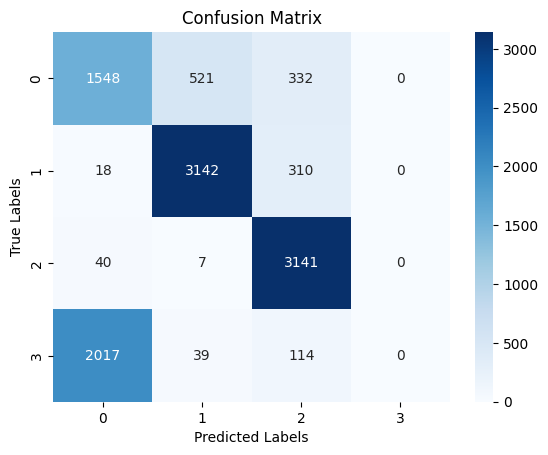

Accuracy :69.73906848339122%
Epoch 76/150, Loss: 1.1497652530670166


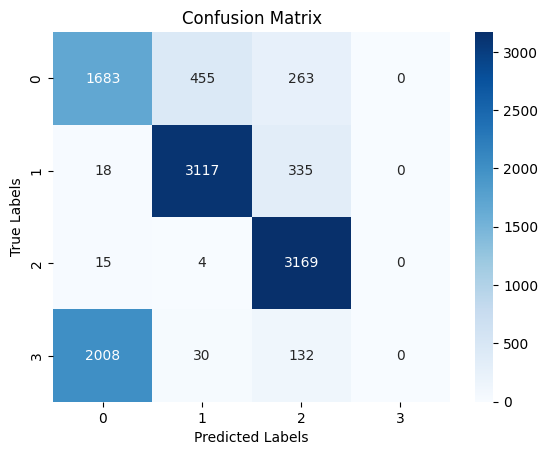

Accuracy :70.96802921008104%
Epoch 77/150, Loss: 1.165968418121338


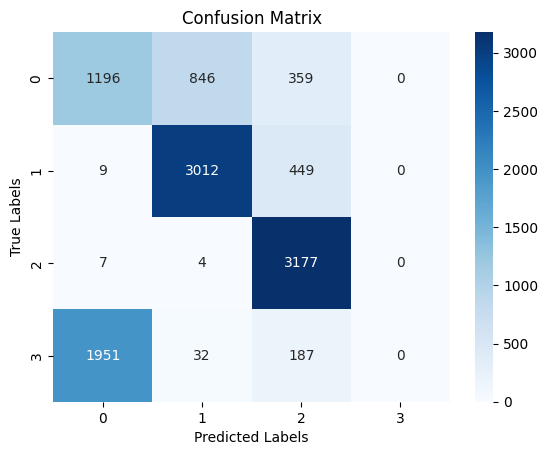

Accuracy :65.7672099029299%
Epoch 78/150, Loss: 1.1682307720184326


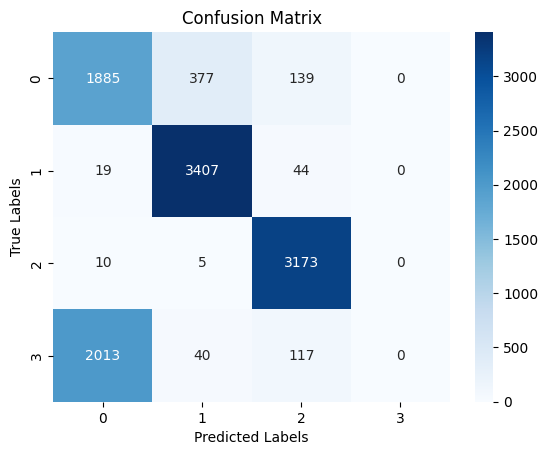

Accuracy :75.3851634161546%
Epoch 79/150, Loss: 1.1834853887557983


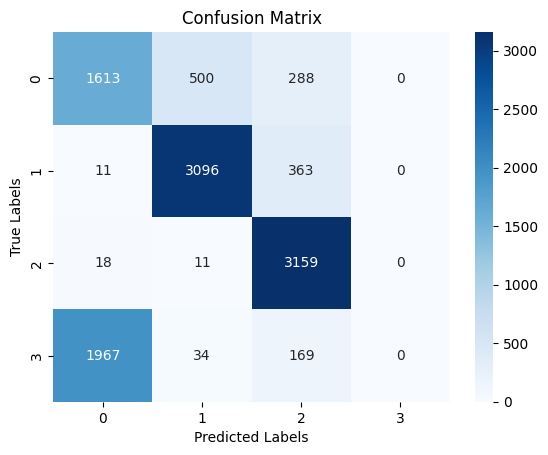

Accuracy :70.06857244634429%
Epoch 80/150, Loss: 1.242775321006775


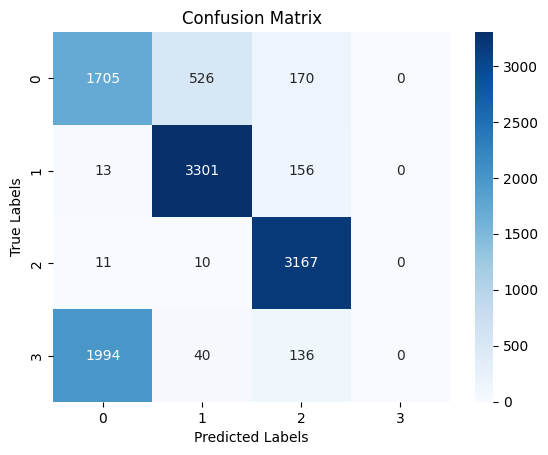

Accuracy :72.78475376257903%
Epoch 81/150, Loss: 1.1758058071136475


Accuracy :74.4768011399056%
Epoch 82/150, Loss: 1.228399395942688


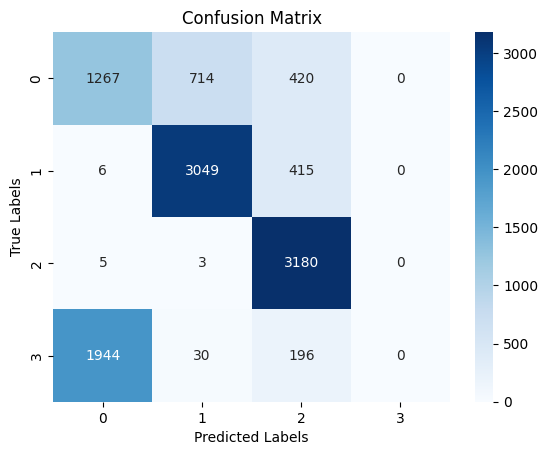

Accuracy :66.75572179178911%
Epoch 83/150, Loss: 1.1883296966552734


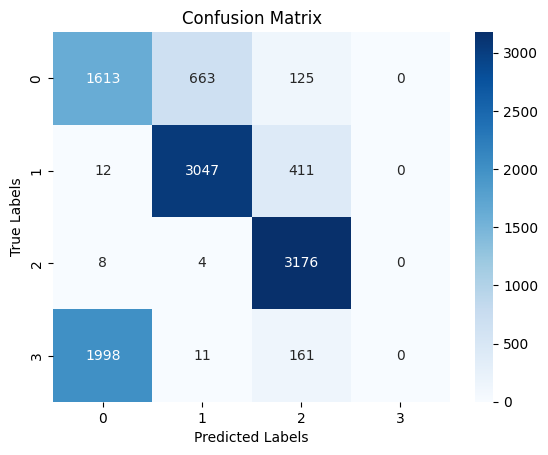

Accuracy :69.78359604595245%
Epoch 84/150, Loss: 1.1866133213043213


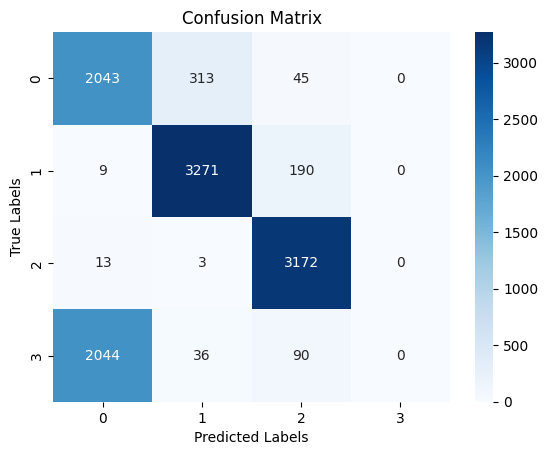

Accuracy :75.57217917891175%
Epoch 85/150, Loss: 1.2353925704956055


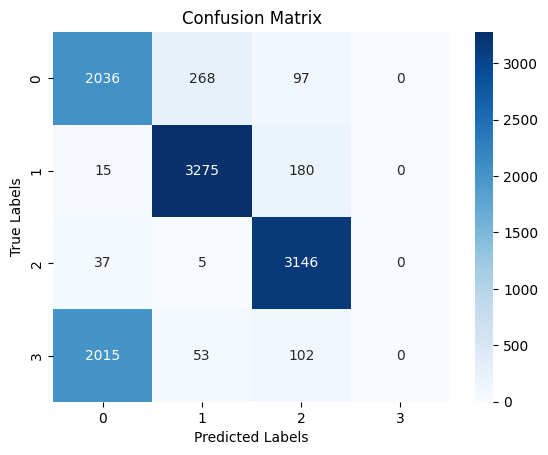

Accuracy :75.31391931605664%
Epoch 86/150, Loss: 1.2638722658157349


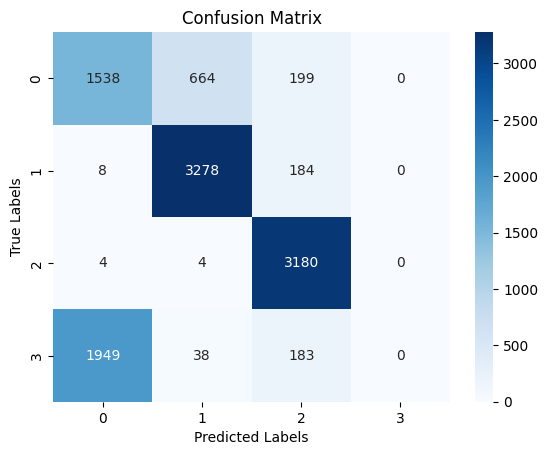

Accuracy :71.20847804791165%
Epoch 87/150, Loss: 1.1451529264450073


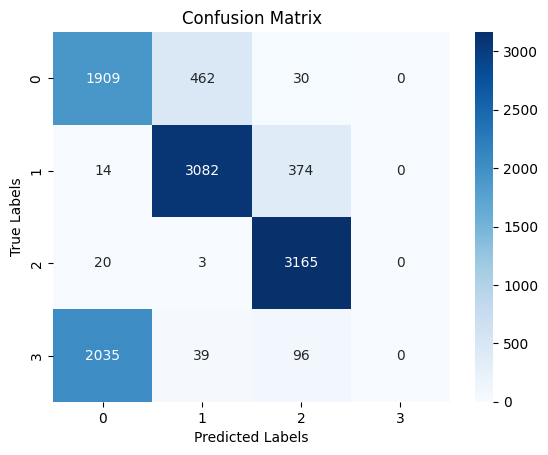

Accuracy :72.63336004987086%
Epoch 88/150, Loss: 1.2787545919418335


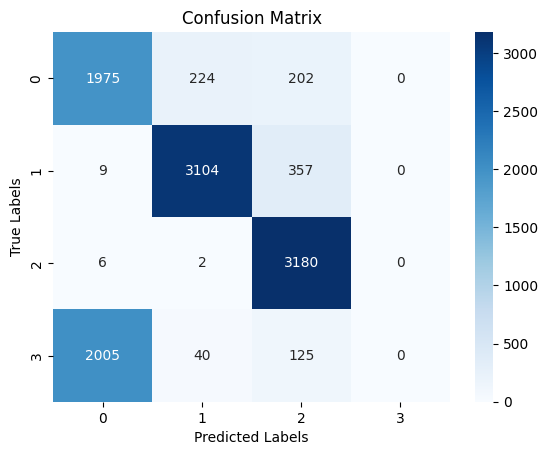

Accuracy :73.55062783863211%
Epoch 89/150, Loss: 1.2608814239501953


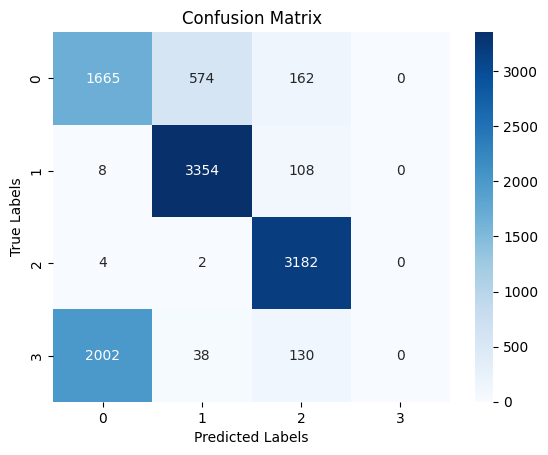

Accuracy :73.0341081129219%
Epoch 90/150, Loss: 1.2101529836654663


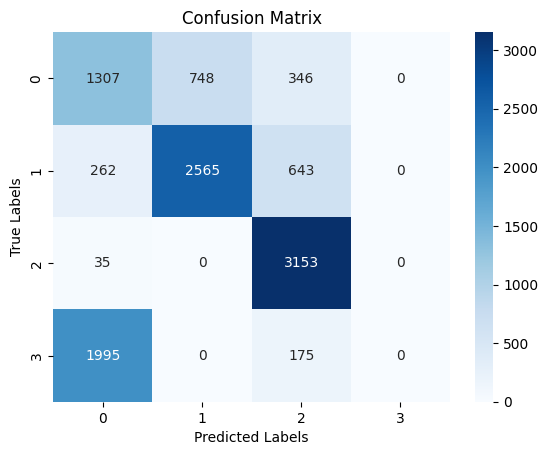

Accuracy :62.56122539852168%
Epoch 91/150, Loss: 1.1802014112472534


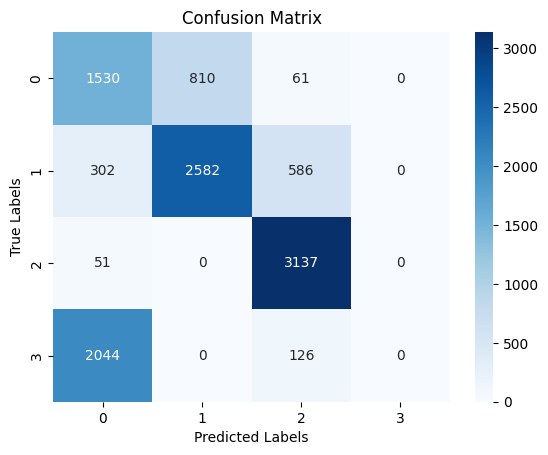

Accuracy :64.55606020126459%
Epoch 92/150, Loss: 1.1791329383850098


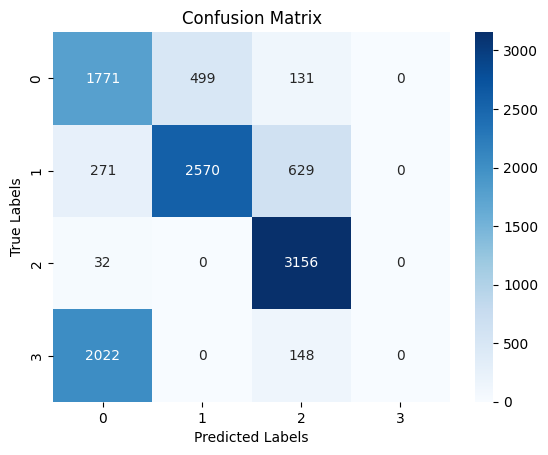

Accuracy :66.76462730430136%
Epoch 93/150, Loss: 1.2488428354263306


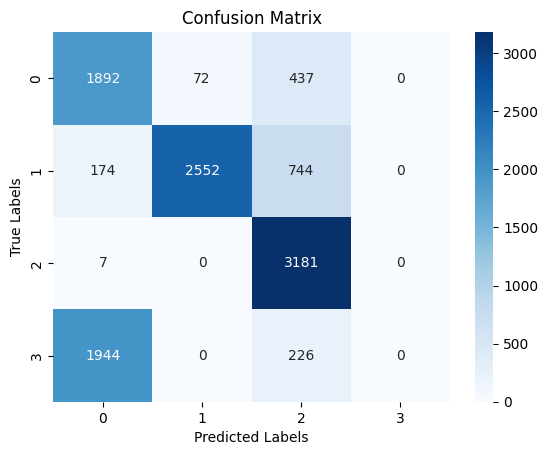

Accuracy :67.90453290586873%
Epoch 94/150, Loss: 1.1512988805770874


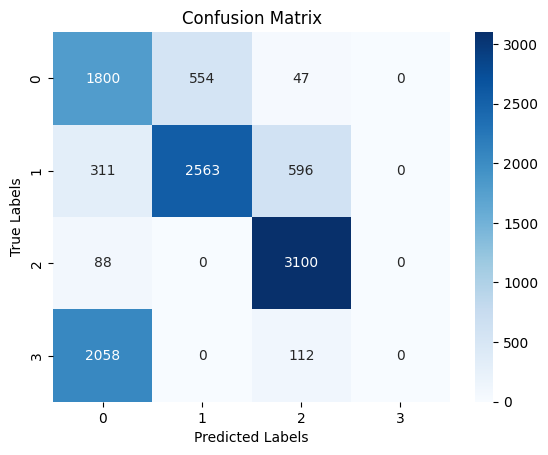

Accuracy :66.46183987888503%
Epoch 95/150, Loss: 1.1492586135864258


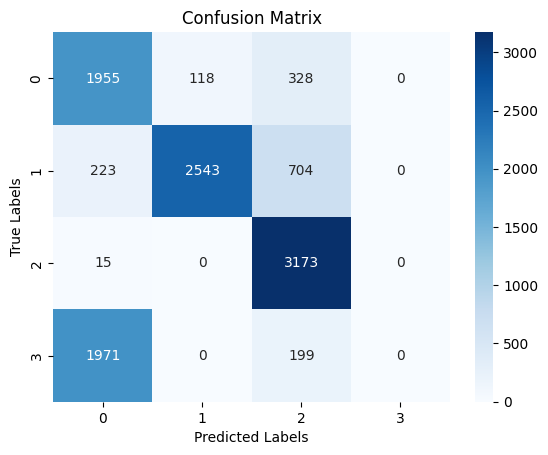

Accuracy :68.314186481432%
Epoch 96/150, Loss: 1.2405766248703003


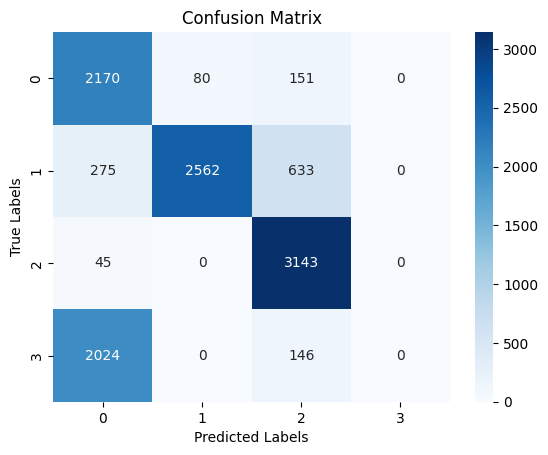

Accuracy :70.13091103393%
Epoch 97/150, Loss: 1.1619545221328735


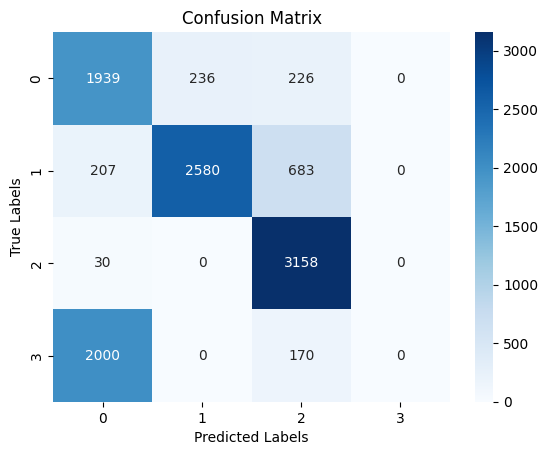

Accuracy :68.36761955650547%
Epoch 98/150, Loss: 1.2354393005371094


Accuracy :68.89304479472793%
Epoch 99/150, Loss: 1.2293275594711304


Accuracy :63.336004987087%
Epoch 100/150, Loss: 1.2013574838638306


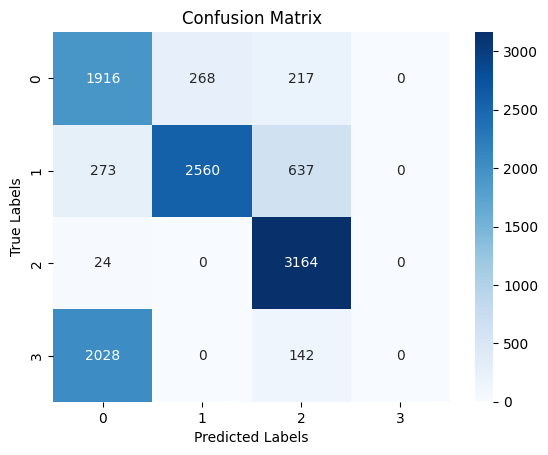

Accuracy :68.0381155935524%
Epoch 101/150, Loss: 1.2375956773757935


Accuracy :63.97720188796865%
Epoch 102/150, Loss: 1.201904535293579


Accuracy :62.77495769881557%
Epoch 103/150, Loss: 1.15290367603302


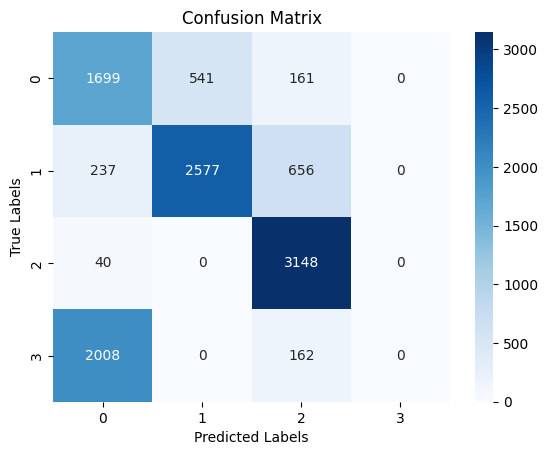

Accuracy :66.11452489090746%
Epoch 104/150, Loss: 1.172548770904541


Accuracy :61.4569418470033%
Epoch 105/150, Loss: 1.150964379310608


Accuracy :65.09929646451154%
Epoch 106/150, Loss: 1.1804972887039185


Accuracy :73.01629708789741%
Epoch 107/150, Loss: 1.2725772857666016


Accuracy :67.63736753050138%
Epoch 108/150, Loss: 1.1451530456542969


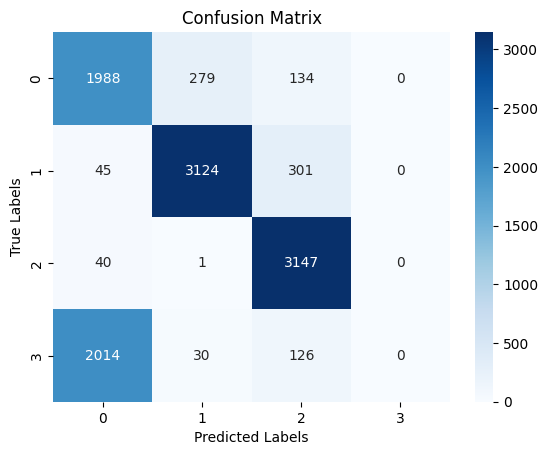

Accuracy :73.55062783863211%
Epoch 109/150, Loss: 1.1744352579116821


Accuracy :72.33057262445453%
Epoch 110/150, Loss: 1.1358853578567505


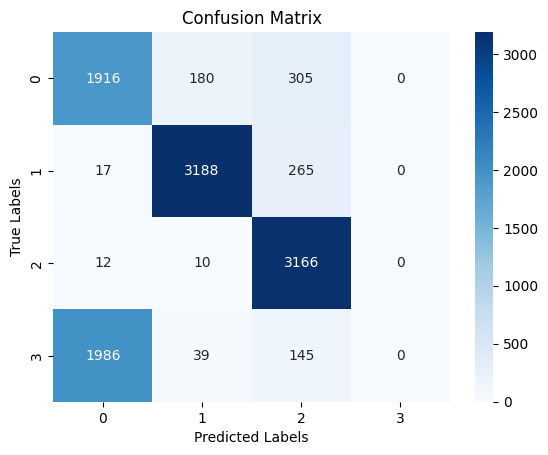

Accuracy :73.64858847626681%
Epoch 111/150, Loss: 1.2113920450210571


Accuracy :68.5902573693116%
Epoch 112/150, Loss: 1.195548415184021


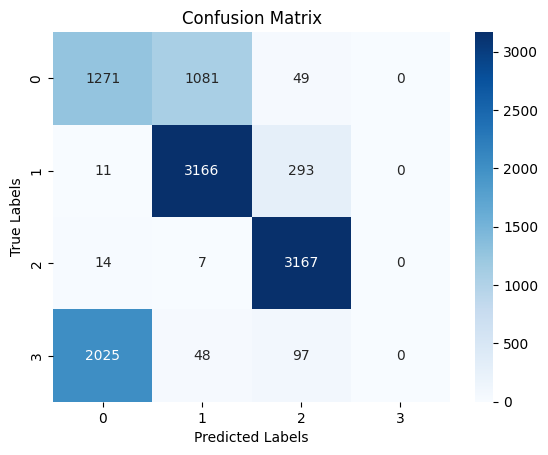

Accuracy :67.71751714311158%
Epoch 113/150, Loss: 1.1992640495300293


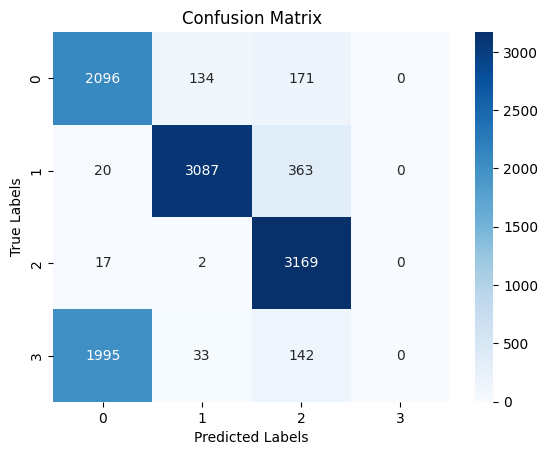

Accuracy :74.3788405022709%
Epoch 114/150, Loss: 1.176511526107788


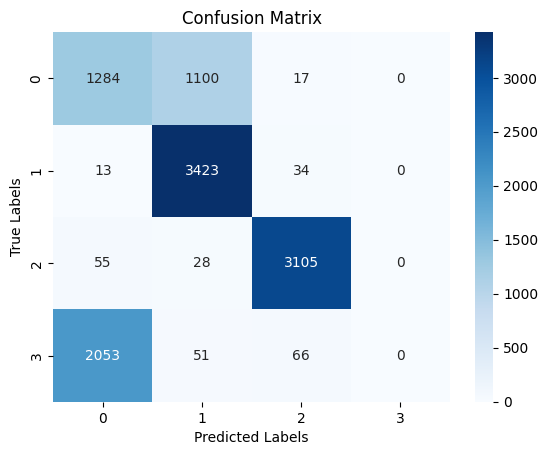

Accuracy :69.56986374565857%
Epoch 115/150, Loss: 1.1685960292816162


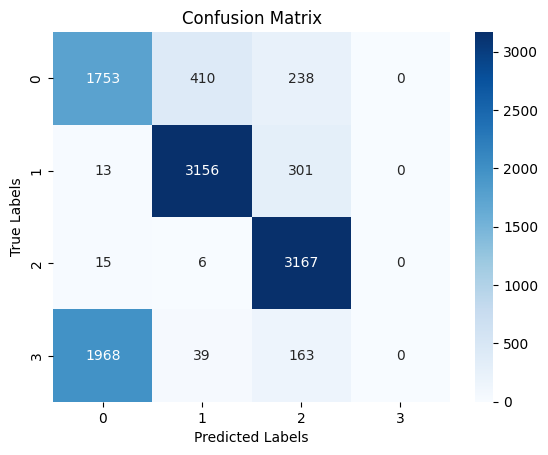

Accuracy :71.92091904889126%
Epoch 116/150, Loss: 1.1866456270217896


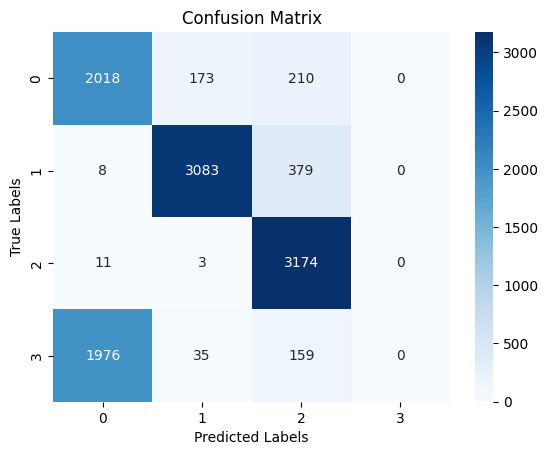

Accuracy :73.69311603882804%
Epoch 117/150, Loss: 1.2526113986968994


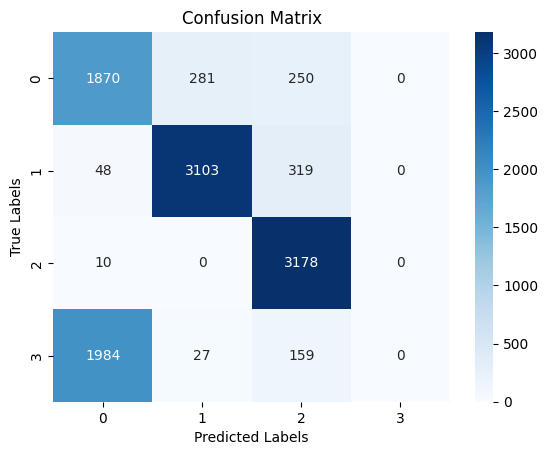

Accuracy :72.58883248730965%
Epoch 118/150, Loss: 1.2200523614883423


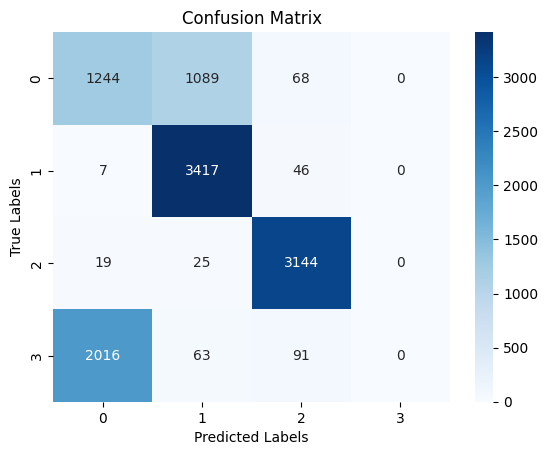

Accuracy :69.50752515807285%
Epoch 119/150, Loss: 1.1723781824111938


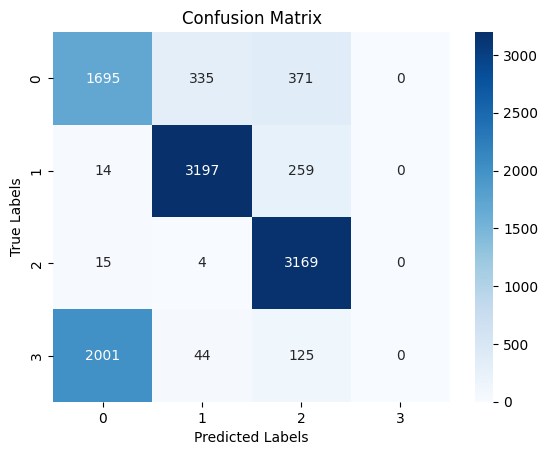

Accuracy :71.7873363612076%
Epoch 120/150, Loss: 1.1397645473480225


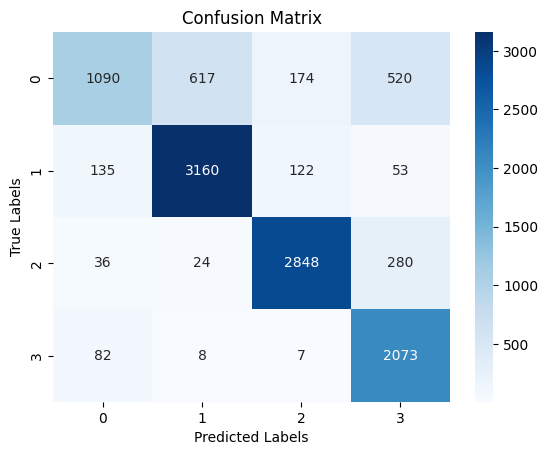

Accuracy :81.67245524979963%
Epoch 121/150, Loss: 1.140487790107727


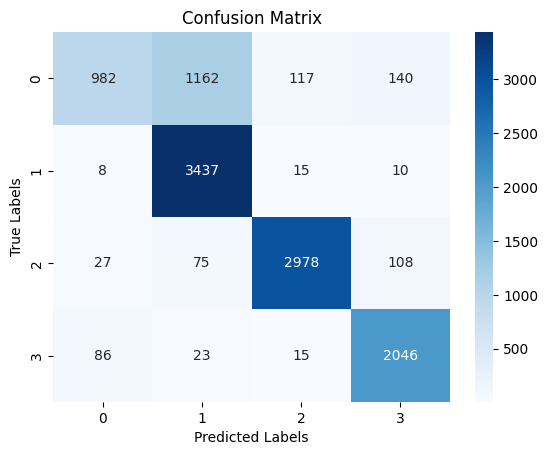

Accuracy :84.0947546531303%
Epoch 122/150, Loss: 1.1172248125076294


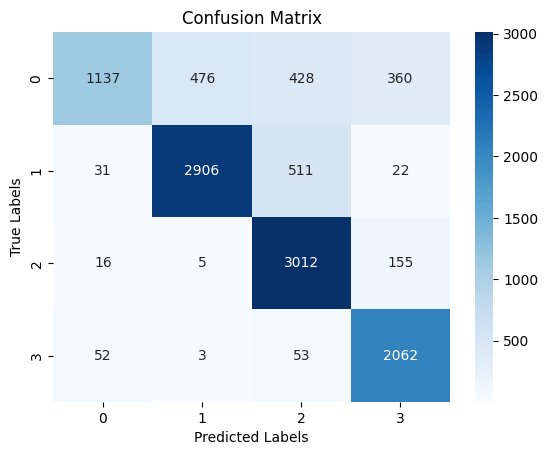

Accuracy :81.1915575741384%
Epoch 123/150, Loss: 1.1297203302383423


Accuracy :87.40760530768546%
Epoch 124/150, Loss: 1.0870555639266968


Accuracy :81.59230563718943%
Epoch 125/150, Loss: 1.1469898223876953


Accuracy :82.93703802653842%
Epoch 126/150, Loss: 1.115126132965088


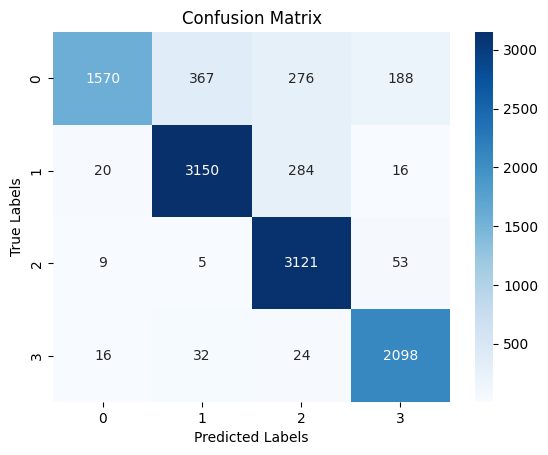

Accuracy :88.51188885920385%
Epoch 127/150, Loss: 1.0937944650650024


Accuracy :79.24125033395671%
Epoch 128/150, Loss: 1.1163678169250488


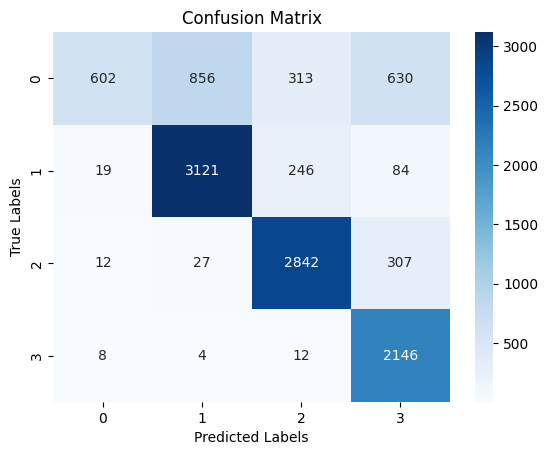

Accuracy :77.5759194941669%
Epoch 129/150, Loss: 1.141337513923645


Accuracy :89.04621960993855%
Epoch 130/150, Loss: 1.1230791807174683


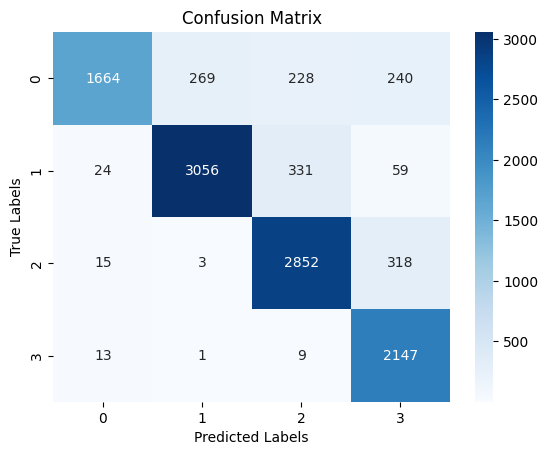

Accuracy :86.55267610650994%
Epoch 131/150, Loss: 1.0917129516601562


Accuracy :86.43690444385075%
Epoch 132/150, Loss: 1.1005573272705078


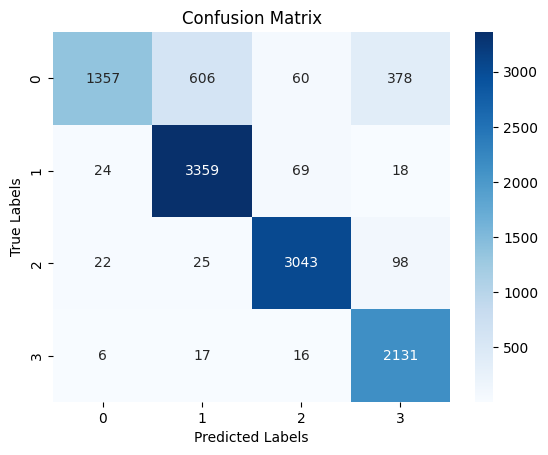

Accuracy :88.07551874610384%
Epoch 133/150, Loss: 1.1085946559906006


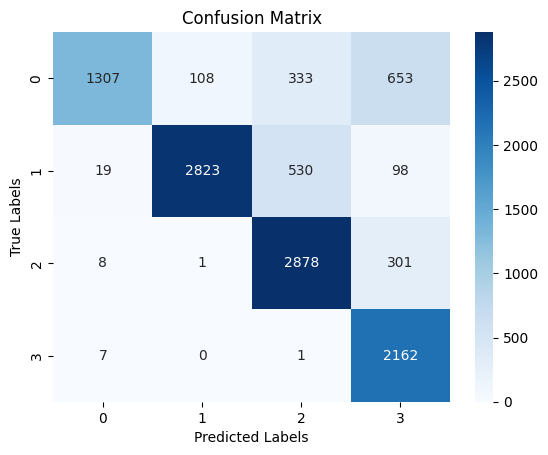

Accuracy :81.66354973728738%
Epoch 134/150, Loss: 1.10768461227417


Accuracy :90.48891263692227%
Epoch 135/150, Loss: 1.125179409980774


Accuracy :82.8925104639772%
Epoch 136/150, Loss: 1.1479814052581787


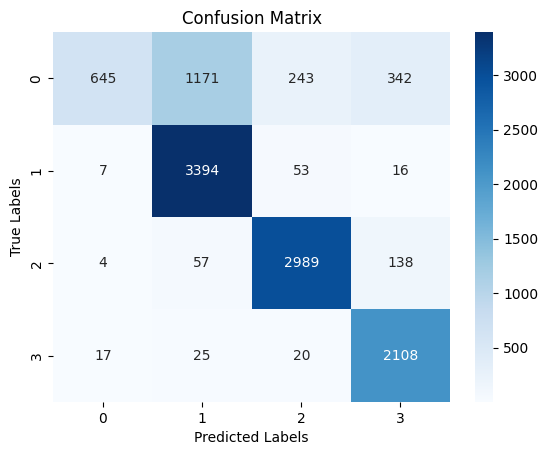

Accuracy :81.36076231187104%
Epoch 137/150, Loss: 1.1343845129013062


Accuracy :82.70549470122005%
Epoch 138/150, Loss: 1.1267374753952026


Accuracy :88.13785733368955%
Epoch 139/150, Loss: 1.1326735019683838


Accuracy :89.91895983613857%
Epoch 140/150, Loss: 1.1173324584960938


Accuracy :86.27660521863034%
Epoch 141/150, Loss: 1.150918960571289


Accuracy :80.53254964823225%
Epoch 142/150, Loss: 1.1223233938217163


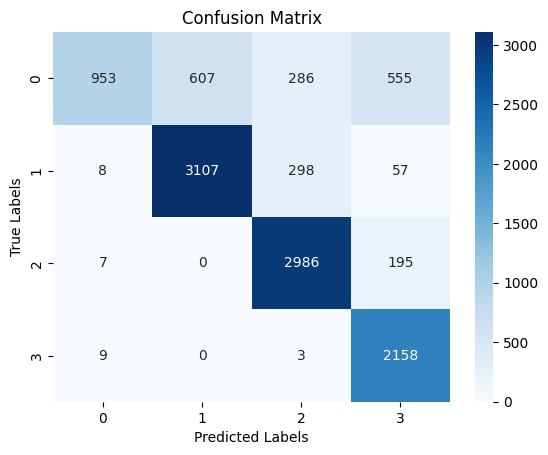

Accuracy :81.96633716270372%
Epoch 143/150, Loss: 1.0735492706298828


Accuracy :89.22432986018345%
Epoch 144/150, Loss: 1.1039777994155884


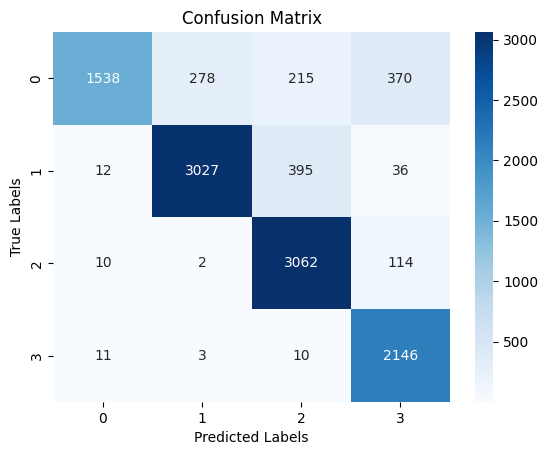

Accuracy :87.03357378217116%
Epoch 145/150, Loss: 1.123644471168518


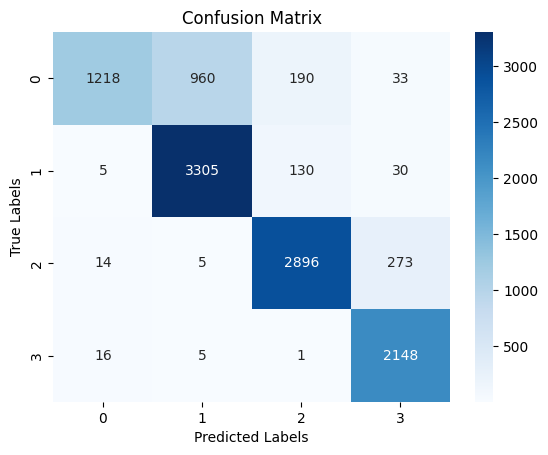

Accuracy :85.19903820464869%
Epoch 146/150, Loss: 1.0747647285461426


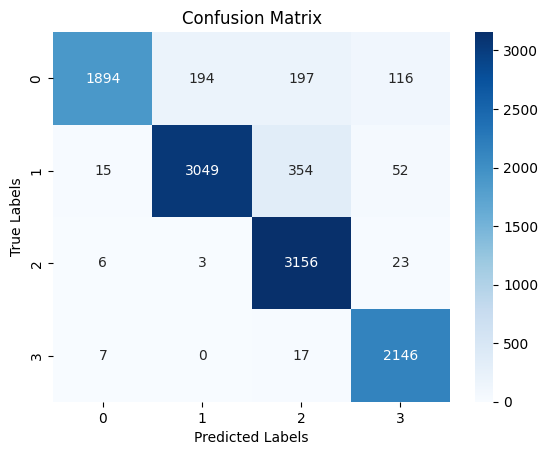

Accuracy :91.23697568795083%
Epoch 147/150, Loss: 1.097644567489624


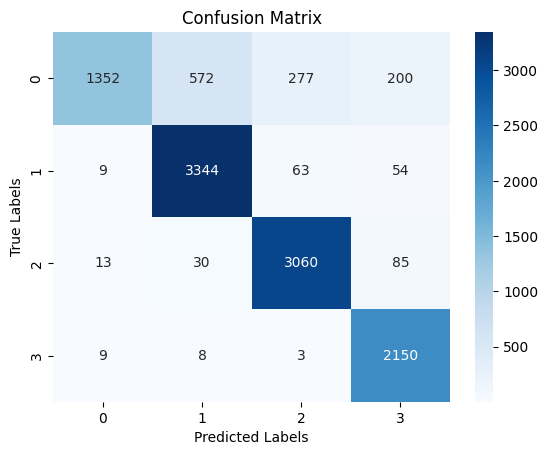

Accuracy :88.21800694629975%
Epoch 148/150, Loss: 1.119994044303894


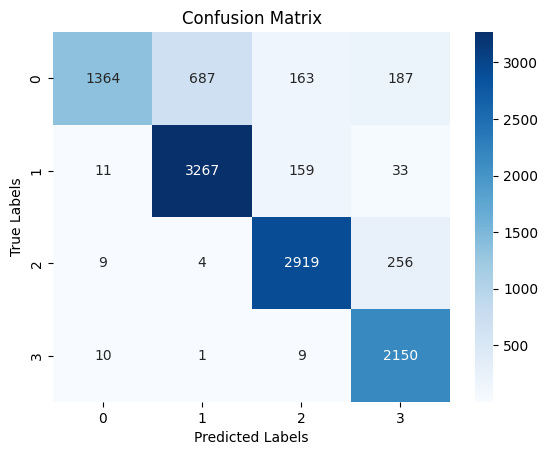

Accuracy :86.38347136877728%
Epoch 149/150, Loss: 1.1145318746566772


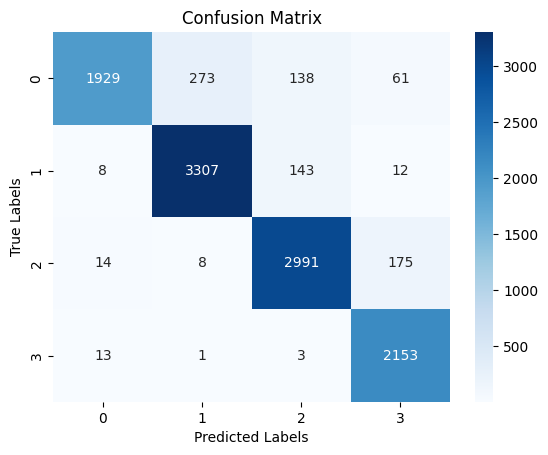

Accuracy :92.43921987710392%
Epoch 150/150, Loss: 1.1305820941925049


In [ ]:
# Define a function to reset the model and optimizer
def reset_model_and_optimizer():
    model.apply(weight_reset)  # Reset model parameters to initial state
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)  # Reinitialize optimizer
    model.to(device)  # Move model to the appropriate device

# Weight reset function to be used with model.apply()
def weight_reset(m):
    if isinstance(m, nn.Conv1d) or isinstance(m, nn.Linear):
        m.reset_parameters()

plot_accuracy = []
plot_loss = []

best_model_epoch = 0
num_epochs = 150
save_interval = 30

for epoch in range(num_epochs):
    for inputs, targets in training_dataloader:
        inputs = inputs.to(device, dtype=torch.float32)
        targets = targets.to(device, dtype=torch.float32)
        # Forward pass
        outputs = model(inputs)
        # Reshape the target tensor
        targets = targets.view(-1, 4)

        loss = criterion(outputs, targets)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    round_loss, round_accuracy = test(model, test_dataloader, criterion)
    plot_loss.append(round_loss)
    plot_accuracy.append(round_accuracy)

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Perform validation on the validation dataset and calculate accuracy
    model.eval()
    with torch.no_grad():
        total_correct = 0
        total_samples = 0
        for val_inputs, val_targets in test_dataloader:
            val_inputs = val_inputs.to(torch.float32).to(device)
            val_targets = val_targets.to(torch.float32).to(device)

            check_label = torch.Tensor()
            check_label = torch.argmax(val_targets, dim=1)

            val_outputs = model(val_inputs)
            _, predicted = torch.max(val_outputs.data, 1)
            total_samples += val_targets.size(0)
            total_correct += (predicted == check_label).sum().item()
        validation_accuracy = total_correct / total_samples

    # Save the model checkpoint only if it's better than the previous best
    if validation_accuracy > best_accuracy:
        best_accuracy = validation_accuracy
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'best_accuracy': best_accuracy,
            # Add any other information you want to save
        }, '/content/drive/MyDrive/專題/Chow model/best_model.pth')
        best_model_epoch = epoch+1
        print(f'Best model saved, epoch = {epoch+1}.')

    # Save the model checkpoint every 20 epochs
    if (epoch + 1) % save_interval == 0:
        torch.save({
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'epoch': epoch + 1,
            'best_accuracy': best_accuracy,
            # Add any other information you want to save
        }, f'/content/drive/MyDrive/專題/Chow model/checkpoint_epoch_{epoch+1}.pth')
        reset_model_and_optimizer()


# Training model

Epoch 1/50, Loss: 1.175689697265625


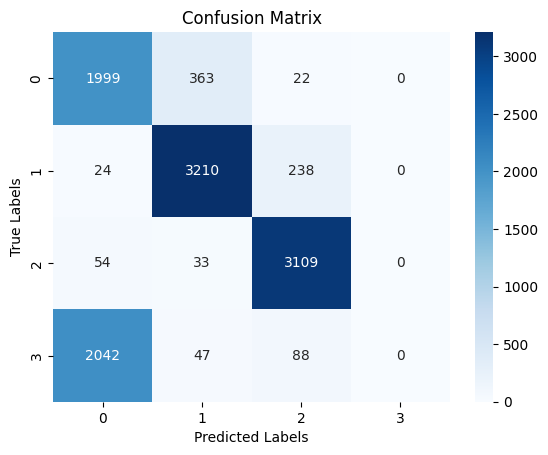

Epoch 2/50, Loss: 1.1534854173660278


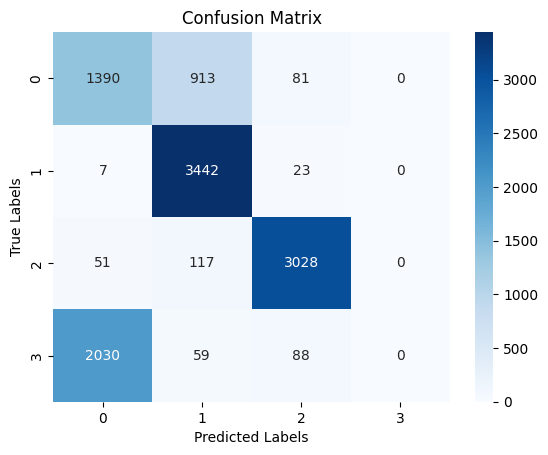

Epoch 3/50, Loss: 1.1596029996871948


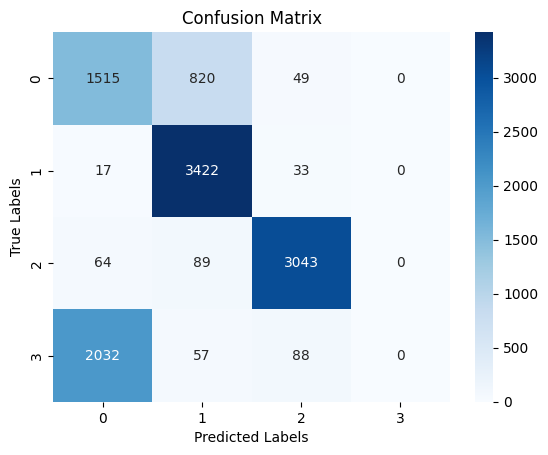

Epoch 4/50, Loss: 1.162922978401184


Epoch 5/50, Loss: 1.2197480201721191


Epoch 6/50, Loss: 1.1186634302139282


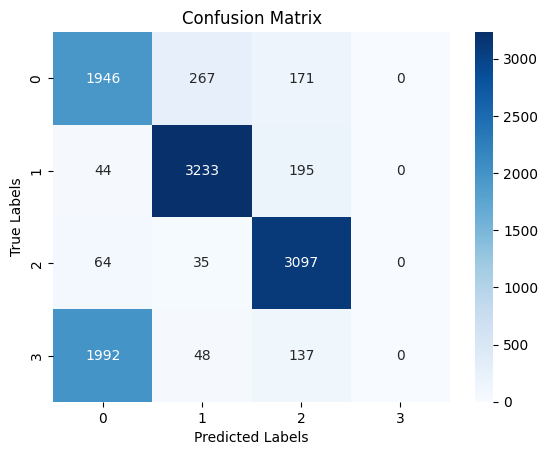

Epoch 7/50, Loss: 1.2163277864456177


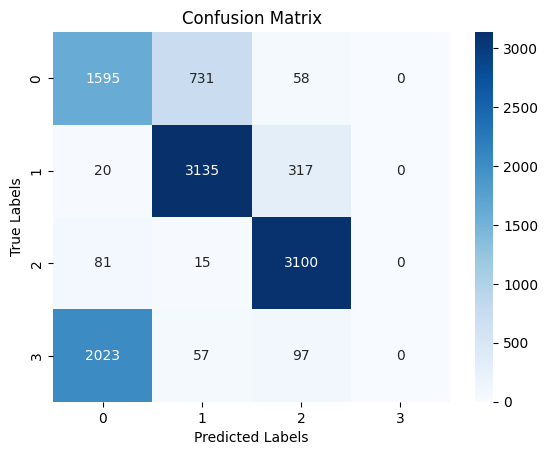

Epoch 8/50, Loss: 1.1600992679595947


Epoch 9/50, Loss: 1.1704518795013428


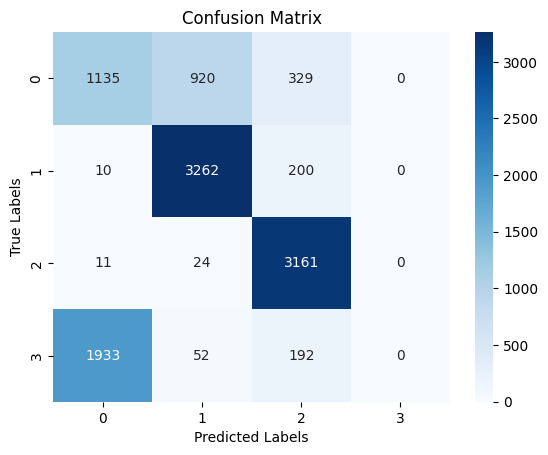

Epoch 10/50, Loss: 1.1483652591705322


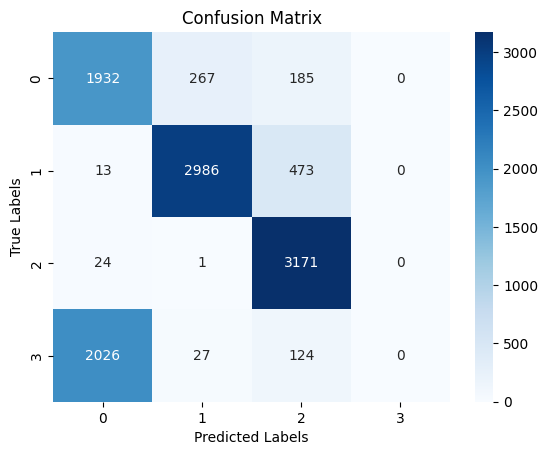

Epoch 11/50, Loss: 1.194164752960205


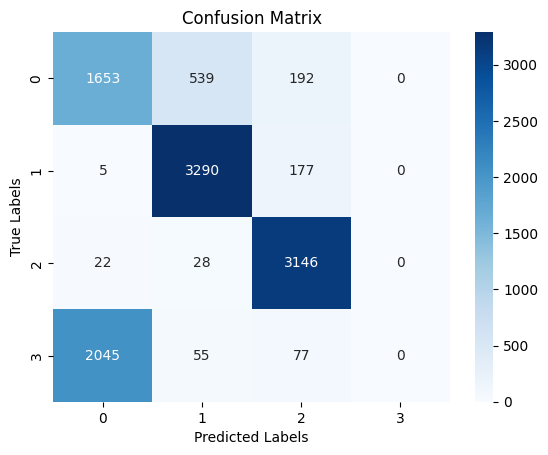

Epoch 12/50, Loss: 1.2065354585647583


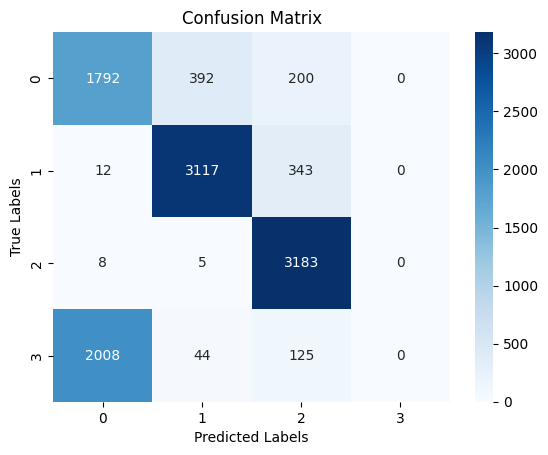

Epoch 13/50, Loss: 1.1440870761871338


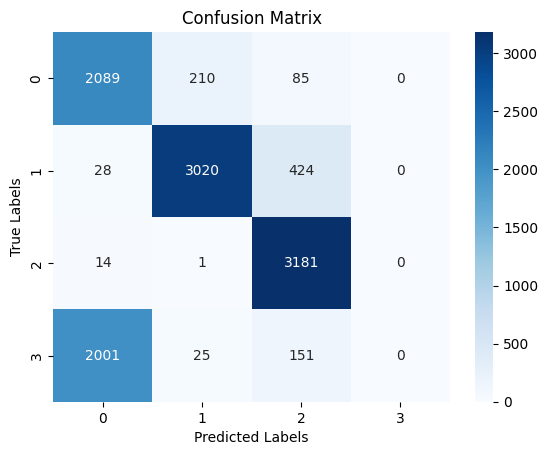

Epoch 14/50, Loss: 1.180031657218933


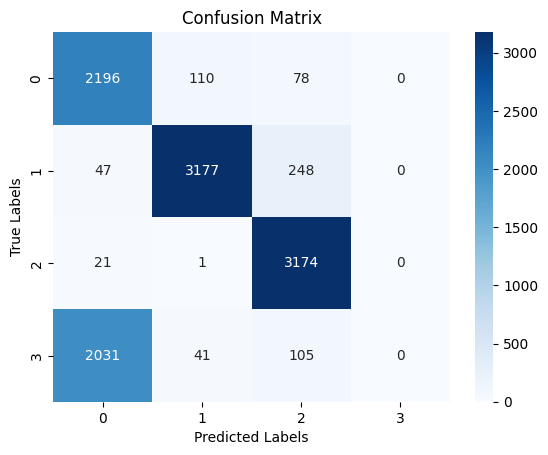

Epoch 15/50, Loss: 1.155687928199768


Epoch 16/50, Loss: 1.2581473588943481


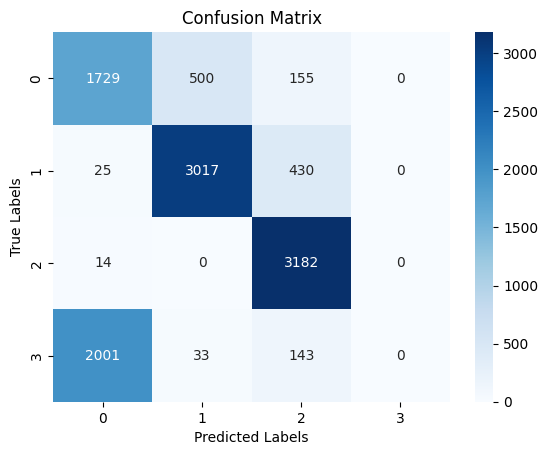

Epoch 17/50, Loss: 1.1939531564712524


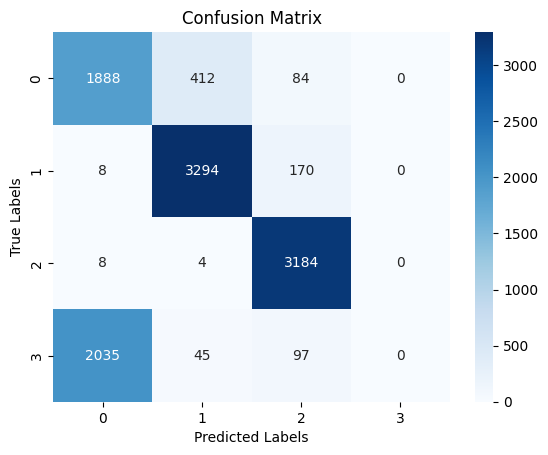

Epoch 18/50, Loss: 1.1061937808990479


Epoch 19/50, Loss: 1.1843507289886475


Epoch 20/50, Loss: 1.1182060241699219


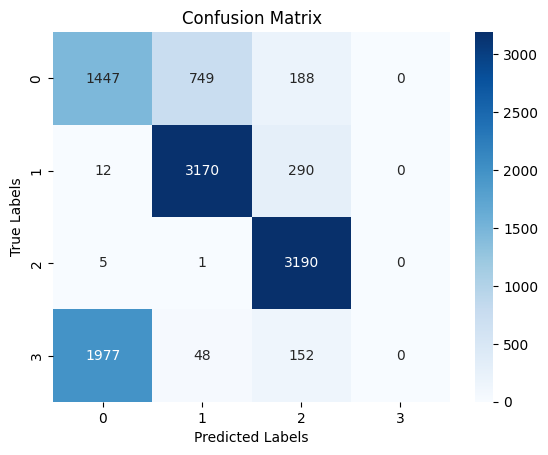

Epoch 21/50, Loss: 1.2104337215423584


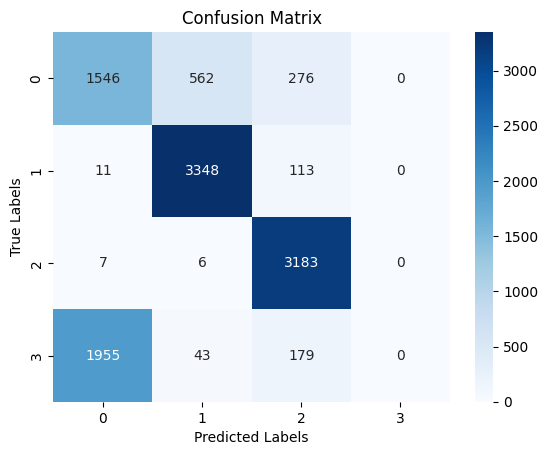

Epoch 22/50, Loss: 1.21605384349823


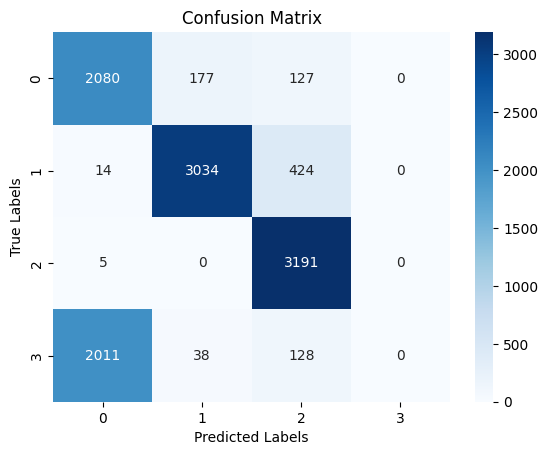

Epoch 23/50, Loss: 1.1601183414459229


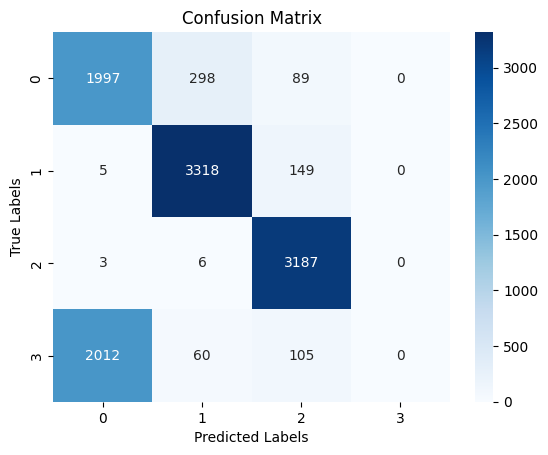

Epoch 24/50, Loss: 1.2492790222167969


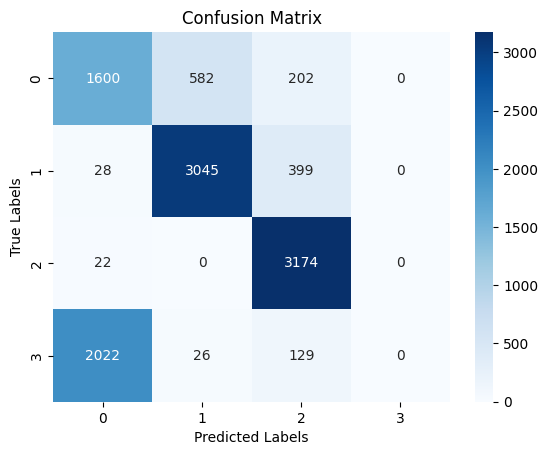

Epoch 25/50, Loss: 1.1989995241165161


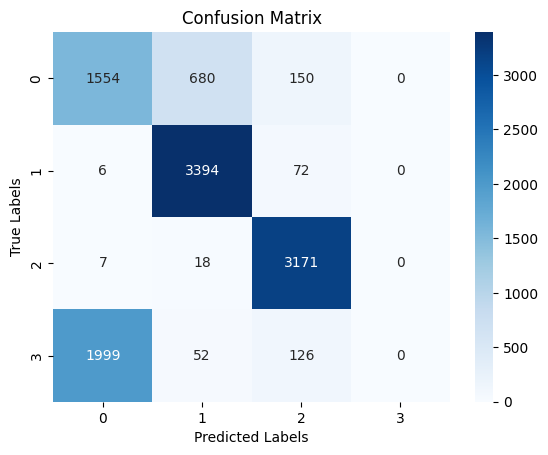

Epoch 26/50, Loss: 1.1682673692703247


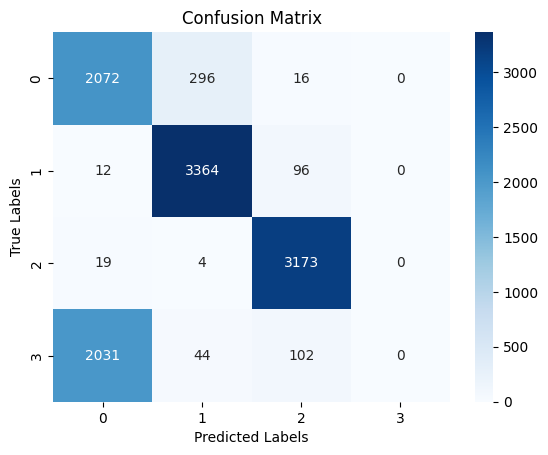

Epoch 27/50, Loss: 1.1994558572769165


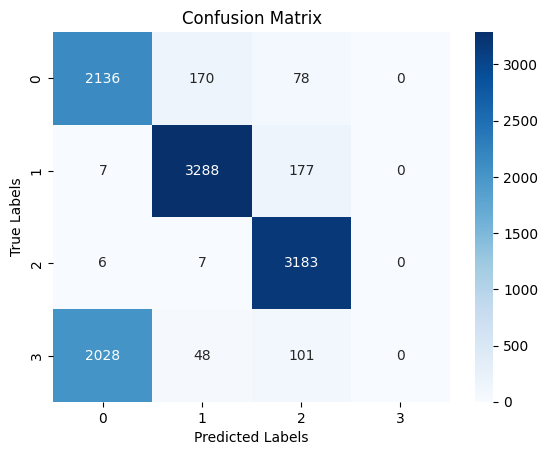

Epoch 28/50, Loss: 1.168321132659912


Epoch 29/50, Loss: 1.1767624616622925


Epoch 30/50, Loss: 1.2171303033828735


Epoch 31/50, Loss: 1.2405507564544678


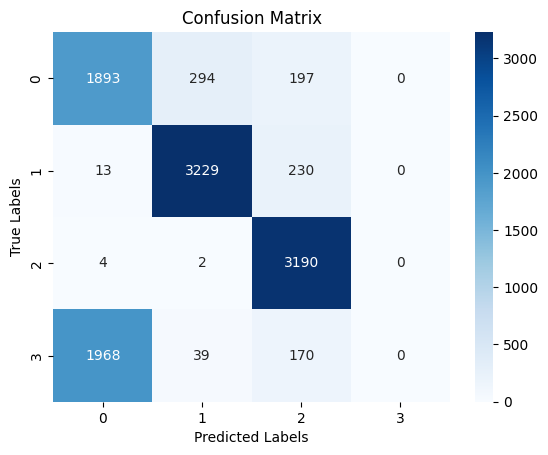

Epoch 32/50, Loss: 1.1992859840393066


Epoch 33/50, Loss: 1.1705704927444458


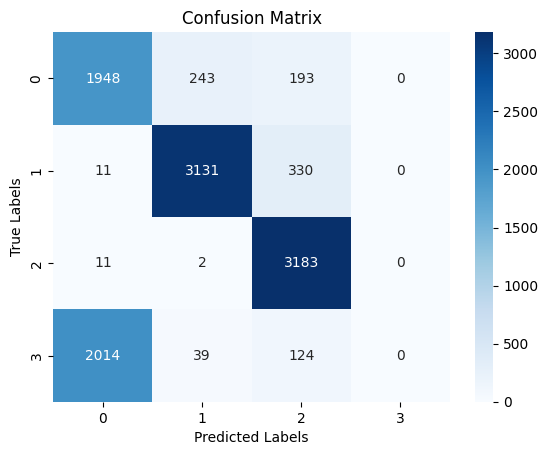

Epoch 34/50, Loss: 1.2296082973480225


Epoch 35/50, Loss: 1.1902250051498413


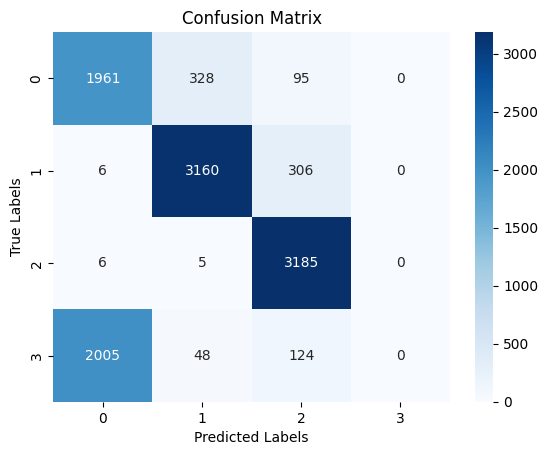

Epoch 36/50, Loss: 1.1677733659744263


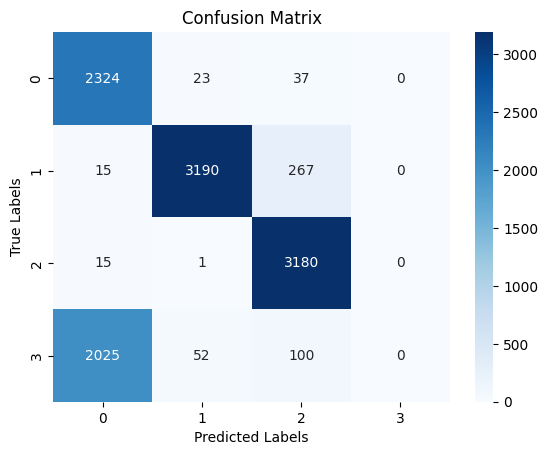

Epoch 37/50, Loss: 1.1036399602890015


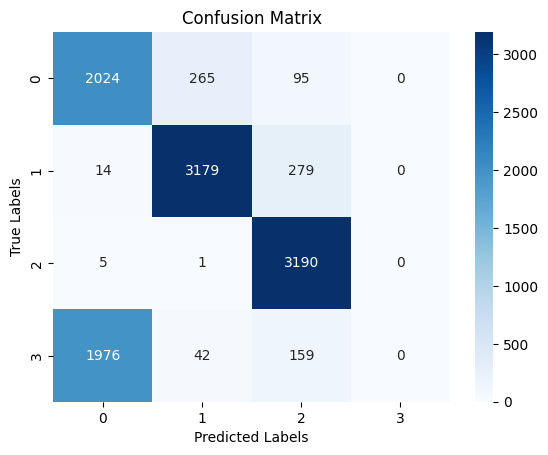

Epoch 38/50, Loss: 1.1467912197113037


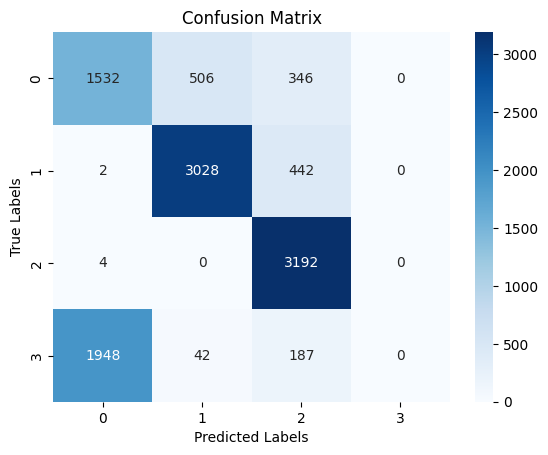

Epoch 39/50, Loss: 1.172938585281372


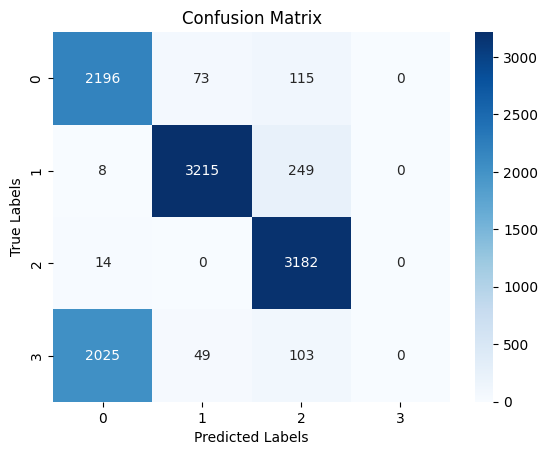

Epoch 40/50, Loss: 1.1351633071899414


Epoch 41/50, Loss: 1.1945589780807495


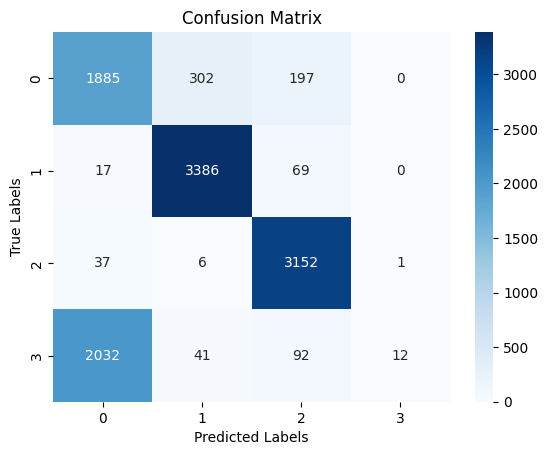

Epoch 42/50, Loss: 1.2065424919128418


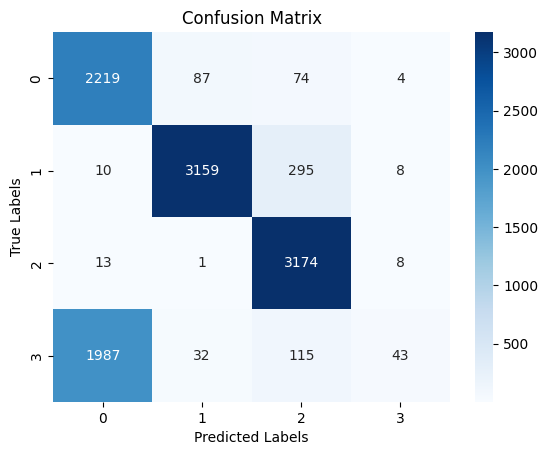

Epoch 43/50, Loss: 1.1367332935333252


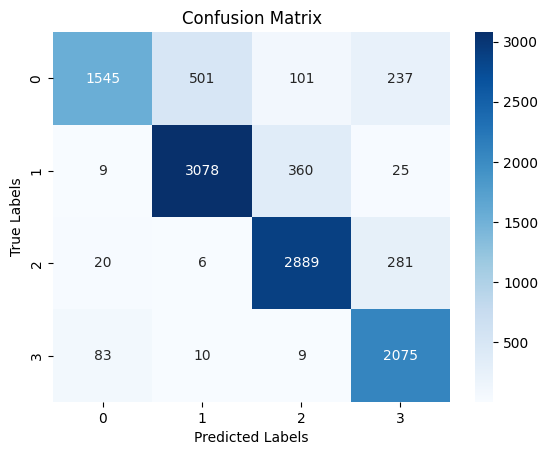

Epoch 44/50, Loss: 1.12045419216156


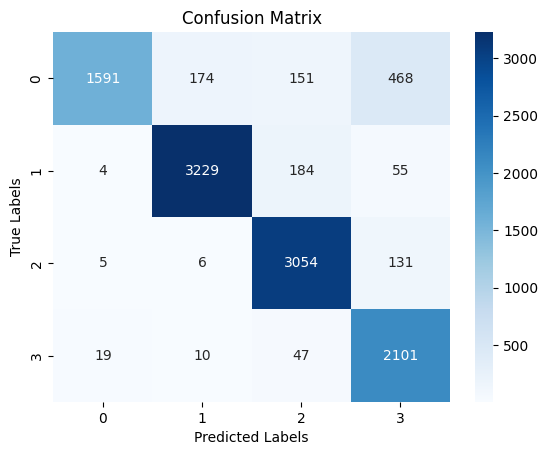

Epoch 45/50, Loss: 1.106762409210205


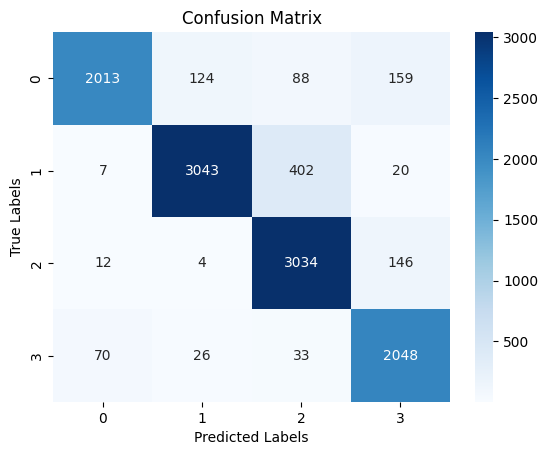

Epoch 46/50, Loss: 1.1650886535644531


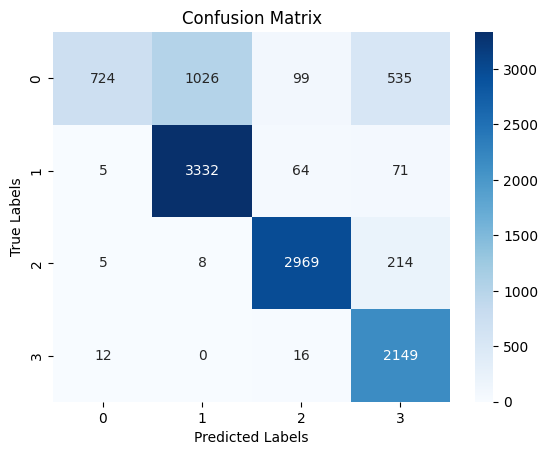

Epoch 47/50, Loss: 1.1131970882415771


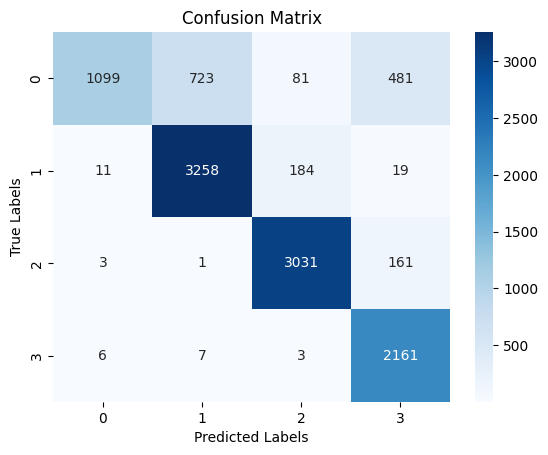

Epoch 48/50, Loss: 1.1038455963134766


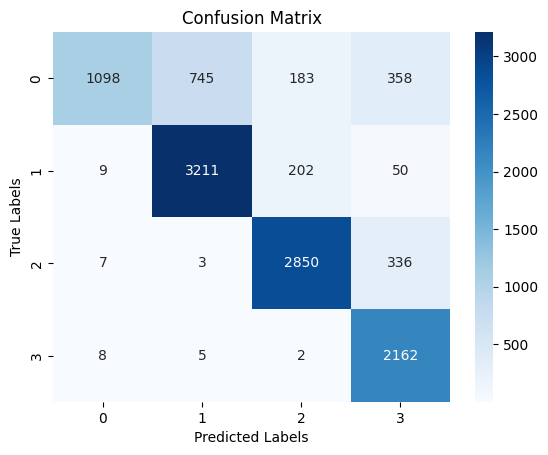

Epoch 49/50, Loss: 1.1017009019851685


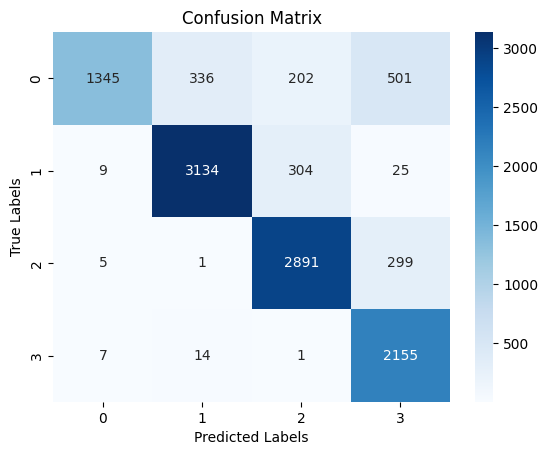

Epoch 50/50, Loss: 1.1065651178359985


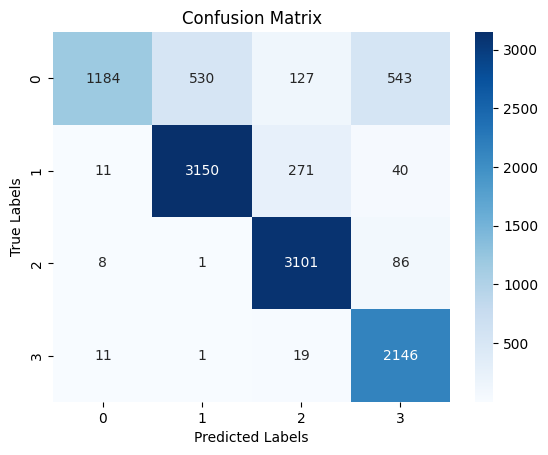

In [ ]:
plot_accuracy = []
plot_loss = []

num_epochs = 50

for epoch in range(num_epochs):
    for inputs, targets in training_dataloader:
      inputs = inputs.to(torch.float32).to(device)
      targets = targets.to(torch.float32).to(device)
      # Forward pass
      outputs = model(inputs)

      # Reshape the target tensor
      targets = targets.view(-1, 4)

      # print(outputs)

      # Compute the loss
      loss = criterion(outputs, targets)

      # Backward pass and optimization
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    # Print the loss for this epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")
    round_loss, round_accuracy = test(model, test_dataloader, criterion)
    plot_loss.append(round_loss)
    plot_accuracy.append(round_accuracy)


# Accuracy

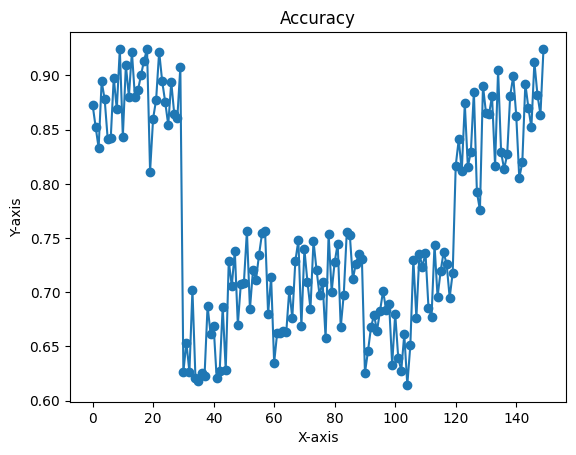

In [ ]:
import matplotlib.pyplot as plt

# Generate x-axis values (0 to len(data) - 1)
accuracy_x = range(len(plot_accuracy))

# Plot the data as a line chart
plt.plot(accuracy_x, plot_accuracy, marker='o')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Accuracy')

# Display the chart
plt.show()


# Loss

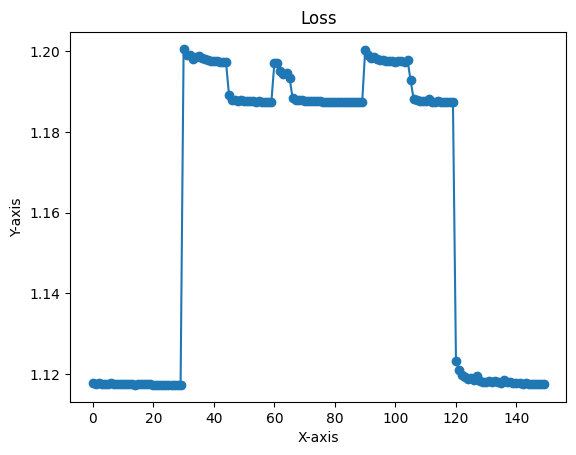

In [ ]:
# Generate x-axis values (0 to len(data) - 1)
loss_x = range(len(plot_loss))

# Plot the data as a line chart
plt.plot(loss_x, plot_loss, marker='o')

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Loss')

# Display the chart
plt.show()


# Check best model

In [ ]:
checkpoint = torch.load('/content/drive/MyDrive/專題/Chow model/best_model.pth')

print(best_model_epoch)

0


In [ ]:
model = Majhong_Model()
model.load_state_dict(checkpoint['model_state_dict'])

model = model.to(device)
criterion = criterion.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [ ]:
model.eval()

Majhong_Model(
  (conv1): Conv1d(2, 256, kernel_size=(3,), stride=(1,), padding=same)
  (conv2): Conv1d(256, 256, kernel_size=(3,), stride=(1,), padding=same)
  (conv_last): Conv1d(256, 32, kernel_size=(3,), stride=(1,))
  (fc1): Linear(in_features=1024, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=4, bias=True)
  (relu): ReLU()
  (softmax): Softmax(dim=1)
)

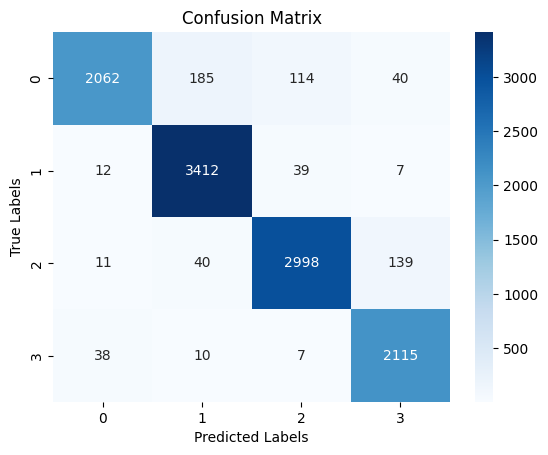

Accuracy :94.28266096713865%


(1.1178652295893028, 0.9428266096713865)

In [ ]:
test(model, test_dataloader, criterion)


# ResNet

In [ ]:
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        # self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        # self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        # out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        # out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
# Using ResNet
class Majhong_Model(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(Majhong_Model, self).__init__()
        self.in_channels = 256
        self.conv1 = nn.Conv1d(in_channels=2, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv2 = nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same')
        self.conv_last = nn.Conv1d(in_channels=256, out_channels=32, kernel_size=3, stride=1)

        self.layer1 = self.make_layer(block, 256, layers[0])
        self.layer2 = self.make_layer(block, 256, layers[0], 2)

        self.fc1 = nn.Linear(1024, 256)
        self.fc2 = nn.Linear(256, 4)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                nn.Conv1d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding='same'),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(in_channels=256, out_channels=256)) # 残差直接映射部分
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        batch_size = x.size(0)
        out = self.conv1(x)
        out = self.relu(out)

        # residual block
        for i in range(5):
          out = self.layer1(out)
          out = self.layer2(out)

        out = self.conv_last(out)
        out = self.relu(out)
        out = out.view(batch_size, -1)  # Flatten the output of convolutional layer
        # out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out
